# Example Circuit
In this notebook, we demonstrate an example spatio-temporal circuit of the Antennal Lobe with the following configuration:

1. Pre-LN: Global Feedback Inhibition of OSN Axon-Terminal
2. Post-eLN: Local Feedforward Excitation of PN
3. Post-iLN: Local Feedforward Inhibition of PN

Note that the model described here is a rate-based model, where the Frequency-Current curve
of the Biophysical Spike Generators (e.g. PN Axon Hillock) are represented as 
Poisson Spike Generators. The rate of the Poisson Processes of each BSG is represented
by the Frequency-Current curve of a Noisy Connor-Stevens neuron. 
This was done for computational efficiency, which allows the massive experimentations 
across parameterizations and circuit configurations in our work.
However, note that the circuit can be easily changed to a spiking network by changing 
the model describing each BSG in the circuit.

See [[LAY20]](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007751#sec037) for more details on the Noisy Connor-Stevens neuron model.

In [2]:
import random
import pandas as pd
import numpy as np
import pycuda.autoprimaryctx
from neural.basemodel import Model
from neural.network import Network
from neural.network.operator import Operator, Repeat, Add
from pycuda.elementwise import ElementwiseKernel
import pycuda.gpuarray as garray
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib as mpl
import skcuda
import skcuda.misc
skcuda.misc.init()

In [3]:
from antennal_lobe.experiments.data import estimate_current, estimate_spike_rate

In [4]:
def snr(sig, noise, dt):
    sig_power = np.trapz(sig**2, dx=dt)
    noise_power = np.trapz(noise**2, dx=dt)
    return 10*np.log10(sig_power/noise_power)

### Loading I/O

In [149]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]
pn = data['pn_output'][2]
dt = t[1] - t[0]

aff = df_aff.loc['acetone'].values # affinity rate of acetone
aff2 = df_aff.loc['ethyl acetate'].values
dr = 10. # dissociation rate fixed
N_r = len(aff) # N_r: number of receptors

In [9]:
aff_zeroed = np.clip(df_aff - 1e-5, 0, np.inf)

<AxesSubplot:>

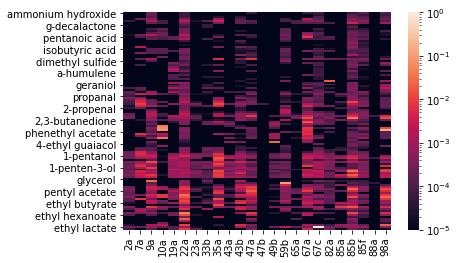

In [10]:
sns.heatmap(df_aff, norm=mpl.colors.LogNorm())

### Model Definitions

In [11]:
class PostLNSyn(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0), x2=(0.0, 0.0, 1.0), x3=(1.0, 0.0, 1.0), I=0.0
    )
    Default_Params = dict(
        a1=1.0,
        b1=1.0,
        k=10.0,
        a2=1.0,
        b2=1.0,
        a3=1.0,
        b3=1.0,
        gmax=1.0,
    )

    def ode(self, u=0.0):
        self.d_x1 = self.a1 * self.x2 * (1.0 - self.x1) - self.b1 * self.x1- self.k * self.x1 * self.x3
        self.d_x2 = self.a2 * u * (1.0 - self.x2) - self.b2 * self.x2
        self.d_x3 = self.a3 * u * (1.0 - self.x3) - self.b3 * self.x3
        self.I = self.x1 * self.gmax


class PreLN(Operator):
    """BlockMean +  Repeat"""

    def __init__(self, operation="mean", block_size=1, **kwargs):
        self.operation = operation
        self.block_size = block_size
        mean_output_size = int(kwargs["size"] // block_size)
        super().__init__(**kwargs)
        self.meaned = garray.empty(mean_output_size, dtype=self.dtype)

        self._repeat_kernel = ElementwiseKernel(
            "{0} *output, {0} *input".format(self.dtype),
            "output[i] = input[i / {}]".format(self.block_size),
            "Repeat",
        )

    def update(self, input):
        if np.isscalar(input):
            input = np.array([input])
        _input = input.reshape(-1, self.block_size)
        if self._backend == "cuda":
            if self.operation == "mean":
                skcuda.misc.mean(_input, out=self.meaned, axis=1)
            elif self.operation == "sum":
                skcuda.misc.sum(_input, out=self.meaned, axis=1)
            elif "norm" in self.operation:
                degree = float(self.operation.split("norm-")[-1])
                skcuda.misc.sum((_input ** degree), out=self.meaned, axis=1)
                self.meaned = self.meaned ** (1./degree)
            else:
                raise TypeError
            self._repeat_kernel(self.output, self.meaned)
        else:
            raise NotImplementedError

# class PreLN(Operator):
#     """BlockMean +  Repeat"""

#     def __init__(self, operation="mean", block_size=1, **kwargs):
#         assert operation in ["mean", "sum"]
#         self.operation = operation
#         self.block_size = block_size
#         mean_output_size = int(kwargs["size"] // block_size)
#         super().__init__(**kwargs)
#         self.meaned = garray.empty(mean_output_size, dtype=self.dtype)

#         self._repeat_kernel = ElementwiseKernel(
#             "{0} *output, {0} *input".format(self.dtype),
#             "output[i] = input[i / {}]".format(self.block_size),
#             "Repeat",
#         )

#     def update(self, input):
#         if np.isscalar(input):
#             input = np.array([input])
#         _input = input.reshape(-1, self.block_size)
#         if self._backend == "cuda":
#             if self.operation == "mean":
#                 skcuda.misc.mean(_input, out=self.meaned, axis=1)
#             elif self.operation == "sum":
#                 skcuda.misc.sum(_input, out=self.meaned, axis=1)
#             self._repeat_kernel(self.output, self.meaned)
#         else:
#             raise NotImplementedError


class dDNP(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0),
        I=0.
    )
    Default_Params = dict(
        a1=10.0,
        b1=1.0,
        k=10.0,
        gmax=1.
    )

    def ode(self, u=0.0, l=0.0):
        self.d_x1 = self.a1 * u * (1.0 - self.x1) - self.b1 * self.x1 - self.k * self.x1 * l
        self.I = self.gmax * self.x1


class PoissonCSN0(Model):
    Default_States = dict(
        spike_rate=(0.0, 0.0, 350.0), x=(0.0, 0.0, 1.0), r=0.0, spike=0.0, cx=0.0
    )
    Default_Params = dict(
        x7=7.06672200e-12,
        x6=-4.41125703e-09,
        x5=1.14814892e-06,
        x4=-1.61863859e-04,
        x3=1.34591675e-02,
        x2=-6.79691186e-01,
        x1=2.25636389e01,
        x0=-1.36299580e02,
    )

    def ode(self, I=0.0):
        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I
        self.d_x += Ip * self.x1
        Ip = Ip * I
        self.d_x += Ip * self.x2
        Ip = Ip * I
        self.d_x += Ip * self.x3
        Ip = Ip * I
        self.d_x += Ip * self.x4
        Ip = Ip * I
        self.d_x += Ip * self.x5
        Ip = Ip * I
        self.d_x += Ip * self.x6
        Ip = Ip * I
        self.d_x += Ip * self.x7
        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x


class PoissonCSN(Model):
    Default_States = dict(x=0.0, y=0.0, r=0.0, spike=0.0, cx=0.0)
    Default_Params = dict(
        x6=2.79621009e-09,
        x5=-9.55636291e-07,
        x4=1.25880567e-04,
        x3=-7.79496241e-03,
        x2=1.94672932e-01,
        x1=3.44246777,
        x0=5.11085315,
    )

    def ode(self, I=0.0):

        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I
        self.d_x += Ip * self.x1
        Ip = Ip * I
        self.d_x += Ip * self.x2
        Ip = Ip * I
        self.d_x += Ip * self.x3
        Ip = Ip * I
        self.d_x += Ip * self.x4
        Ip = Ip * I
        self.d_x += Ip * self.x5
        Ip = Ip * I
        self.d_x += Ip * self.x6
        self.y = self.d_x

        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x

class PoissonCSN1(Model):
    Default_States = dict(
        x=(0.0, 0., 1.), 
        r=0.0, 
        spike=0.0, 
        cx=0.0
    )            
    Default_Params = dict(
        x8=  2.62834699e-12,
        x7= -1.18820316e-09,
        x6=  2.24914051e-07,
        x5= -2.30971695e-05,
        x4=  1.38994273e-03,
        x3= -4.88554093e-02,
        x2=  8.87442880e-01,
        x1= -6.90178752e-01,
        x0=  8.95839969e-01,
    )

    def ode(self, I=0.0):
        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x1
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x2
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x3
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x4
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x5
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x6
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x7
        Ip = Ip * I * (I>=0)
        self.d_x += Ip * self.x8
        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x

class OTP(Model):
    Default_States = dict(
        v=(0.0, 0, 1e9),
        I=0.0,
        uh=(0.0, 0.0, 1e9),
        duh=0.0,
        x1=(0.0, 0.0, 1.0),
        x2=(0.0, 0.0, 1.0),
        x3=(0.0, 0.0, 1000.0),
    )
    Default_Params = dict(
        br=1.0,
        dr=1.0,
        gamma=0.215,
        b1=0.8,
        a1=45.0,
        a2=146.1,
        b2=117.2,
        a3=2.539,
        b3=0.9096,
        kappa=8841,
        p=1.0,
        c=0.06546,
        Imax=85.0,
    )

    def ode(self, stimulus=0.0):
        self.d_x1 = self.br * self.v * (1.0 - self.x1) - self.dr * self.x1
        f = np.cbrt(self.x2 * self.x2) * np.cbrt(self.x3 * self.x3)
        self.d_x2 = self.a2 * self.x1 * (1.0 - self.x2) - self.b2 * self.x2 - self.kappa * f
        self.d_x3 = self.a3 * self.x2 - self.b3 * self.x3

        self.I = self.Imax * self.x2 / (self.x2 + self.c)

        self.d_uh = self.duh
        self.d_duh = -2 * self.a1 * self.b1 * self.duh + self.a1 * self.a1 * (stimulus - self.uh)
        self.v = self.uh + self.gamma * self.duh


class IonSyn(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0),
        I=0.0,
    )
    Default_Params = dict(
        a1=10.0,
        b1=1.0,
        gmax=10.0,
    )

    def ode(self, u=0.0):
        self.d_x1 = self.a1 * u * (1.0 - self.x1) - self.b1 * self.x1
        self.I = self.x1 * self.gmax
        
class NoisyConnorStevens(Model):
    """
    Connor-Stevens Model
    """

    Time_Scale = 1e3  # s to ms
    Default_States = dict(
        v=(-60, -80, 80),
        n=(0.0, 0.0, 1.0),
        m=(0.0, 0.0, 1.0),
        h=(1.0, 0.0, 1.0),
        a=(1.0, 0.0, 1.0),
        b=(1.0, 0.0, 1.0),
        spike=0,
        v1=-60.0,
        v2=-60.0,
        refactory=0.0,
    )
    Default_Params = dict(
        ms=-5.3,
        ns=-4.3,
        hs=-12.0,
        gNa=120.0,
        gK=20.0,
        gL=0.3,
        ga=47.7,
        ENa=55.0,
        EK=-72.0,
        EL=-17.0,
        Ea=-75.0,
        sigma=2.05,
        refperiod=1.5,
    )

    def ode(self, I=0.0):

        alpha = np.exp(-(self.v + 50.0 + self.ns) / 10.0) - 1.0
        if abs(alpha) <= 1e-7:
            alpha = 0.1
        else:
            alpha = -0.01 * (self.v + 50.0 + self.ns) / alpha
        beta = 0.125 * np.exp(-(self.v + 60.0 + self.ns) / 80.0)
        n_inf = alpha / (alpha + beta)
        tau_n = 2.0 / (3.8 * (alpha + beta))

        alpha = np.exp(-(self.v + 35.0 + self.ms) / 10.0) - 1.0
        if abs(alpha) <= 1e-7:
            alpha = 1.0
        else:
            alpha = -0.1 * (self.v + 35.0 + self.ms) / alpha
        beta = 4.0 * np.exp(-(self.v + 60.0 + self.ms) / 18.0)
        m_inf = alpha / (alpha + beta)
        tau_m = 1.0 / (3.8 * (alpha + beta))

        alpha = 0.07 * np.exp(-(self.v + 60.0 + self.hs) / 20.0)
        beta = 1.0 / (1.0 + np.exp(-(self.v + 30.0 + self.hs) / 10.0))
        h_inf = alpha / (alpha + beta)
        tau_h = 1.0 / (3.8 * (alpha + beta))

        a_inf = np.cbrt(0.0761 * np.exp((self.v + 94.22) / 31.84) / (1.0 + np.exp((self.v + 1.17) / 28.93)))
        tau_a = 0.3632 + 1.158 / (1.0 + np.exp((self.v + 55.96) / 20.12))
        b_inf = np.power(1 / (1 + np.exp((self.v + 53.3) / 14.54)), 4.0)
        tau_b = 1.24 + 2.678 / (1 + np.exp((self.v + 50) / 16.027))

        i_na = self.gNa * np.power(self.m, 3) * self.h * (self.v - self.ENa)
        i_k = self.gK * np.power(self.n, 4) * (self.v - self.EK)
        i_l = self.gL * (self.v - self.EL)
        i_a = self.ga * np.power(self.a, 3) * self.b * (self.v - self.Ea)

        self.d_v = I - i_na - i_k - i_l - i_a
        self.d_n = (n_inf - self.n) / tau_n + random.gauss(0.0, self.sigma)
        self.d_m = (m_inf - self.m) / tau_m + random.gauss(0.0, self.sigma)
        self.d_h = (h_inf - self.h) / tau_h + random.gauss(0.0, self.sigma)
        self.d_a = (a_inf - self.a) / tau_a + random.gauss(0.0, self.sigma)
        self.d_b = (b_inf - self.b) / tau_b + random.gauss(0.0, self.sigma)

        self.d_refactory = self.refactory < 0

    def post(self):
        self.spike = (self.v1 < self.v2) * (self.v < self.v2) * (self.v > -30.0)
        self.v1 = self.v2
        self.v2 = self.v
        self.spike = (self.spike > 0.0) * (self.refactory >= 0)
        self.refactory -= (self.spike > 0.0) * self.refperiod

In [414]:
np.random.rand()

0.9217252834076934

Specify circuit parameterization

In [12]:
params = {
    "osn_axt": {
        "a1": 101.6,
        "b1": 1.12,
        "k": 1e5
    },
    "osn-to-preln": {
        "a1": 1.06,
        "b1": 15.5,
        "gmax": 3232.6,
    },
    "osn-to-posteln": {
        'a1': 2.858053089117711,
        'b1': 1.4540529550164887,
        'k': 323039.26691518247,
        'a2': 1.5028414134309191,
        'b2': 98.82274646620965,
        'a3': 8.583048572622092,
        'b3': 5.9266873782378555,
        'gmax': 6.791877e+07
        # 'a1': 1.6715276978509699,
        # 'b1': 14.531396405401471,
        # 'k': 246899.115294319,
        # 'a2': 8.790437137355001,
        # 'b2': 37.217816956396454,
        # 'a3': 71.89118189388185,
        # 'b3': 2.8568639066323342,
        # 'gmax': 91451893.88946372
    },
    "osn-to-postiln": {
        # 'a1': 12.537946628371419,
        # 'b1': 3.5533912946105644,
        # 'k': 850654.7752613979,
        # 'a2': 64.39457099988905,
        # 'b2': 14.7847156711102,
        # 'a3': 4.946413745118113,
        # 'b3': 23.05951238421643,
        # 'gmax': 2.463306e+04
        'a1': 9.038009011043401,
        'b1': 81.30204837646579,
        'k': 384165.1012001436,
        'a2': 2.094005529791446,
        'b2': 3.657942885692797,
        'a3': 81.35091649546338,
        'b3': 85.33405338413093,
        'gmax': 516779.02440091287
    },
    "osn_axt-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':1.273e5 * 9.63512603e-01 * .3 * 0.99117256 # .3 for l2
    },
    "posteln-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':20.85 * 1.03949467e+04 * 1.10078624
    },
    "postiln-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':89.5 * -2.87216219e+02 * 1.9 * 1.39649253# 1.9 for l2
    },
    "osn_bsg": {
        "sigma": 0.0025
    },
    "pn_bsg": {
        "sigma": 0.0014
    },
    "preln_bsg": {
        "sigma": 0.
    },
    "posteln_bsg": {
        "sigma": 0.
    },
    "postiln_bsg": {
        "sigma": 0.
    }
}

### Rate-Based Model

#### Acetone

In [ ]:
nn_rate = Network(solver="euler")
inp = nn_rate.input(num=1, name='stim')
inp_repeat = nn_rate.add(Repeat, num=1, rep_size=N_r, name='stim-rep')
osn_otp = nn_rate.add(OTP, num=N_r, br=dr*aff, dr=dr, name='OSN-OTP')
osn_bsg = nn_rate.add(PoissonCSN, num=N_r, name='OSN-BSG')

osn_axt = nn_rate.add(dDNP, num=N_r, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn_rate.add(IonSyn, num=N_r, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn_rate.add(PreLN, num=N_r, operation='norm-2', block_size=N_r, name="Pre-LN Input")
preln = nn_rate.add(PoissonCSN0, num=N_r, name="Pre-LN")
osn_axt_to_pn = nn_rate.add(IonSyn, num=N_r, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn_rate.add(PostLNSyn, num=N_r, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn_rate.add(PoissonCSN0, num=N_r, name="Post-eLN")
posteln_to_pn = nn_rate.add(IonSyn, num=N_r, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn_rate.add(PostLNSyn, num=N_r, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn_rate.add(PoissonCSN0, num=N_r, name="Post-iLN")
postiln_to_pn = nn_rate.add(IonSyn, num=N_r, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn_rate.add(Add, num=N_r, name='PN-Dendrite')
pn_bsg = nn_rate.add(PoissonCSN1, num=N_r, name='PN-BSG')

inp_repeat(input=inp)
osn_otp(stimulus=inp_repeat.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.x, l=preln.x)

preln_syn(u=osn_axt.x1)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)
osn_axt_to_pn(u=osn_axt.x1)

posteln_syn(u=osn_bsg.x)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.x)

postiln_syn(u=osn_bsg.x)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.x)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn_rate.compile(dtype=float, backend="cuda")

osn_bsg.record('x')
posteln.record('x')
postiln.record('x')
posteln_syn.record('x1','I')
postiln_syn.record('x1','I')

posteln_to_pn.record('I')
postiln_to_pn.record('I')

osn_axt.record('x1')
osn_axt_to_pn.record('I')
preln.record('x')
pn_bsg.record('x')
pn_inp.record('output')

Load input signal to the network instance

In [266]:
inp_g = garray.to_gpu(np.ascontiguousarray(stim))
inp(inp_g)

Run Network

In [267]:
nn_rate.run(dt, verbose=True)

  0%|          | 0/175000 [00:00<?, ?it/s]

Plot Model I/O

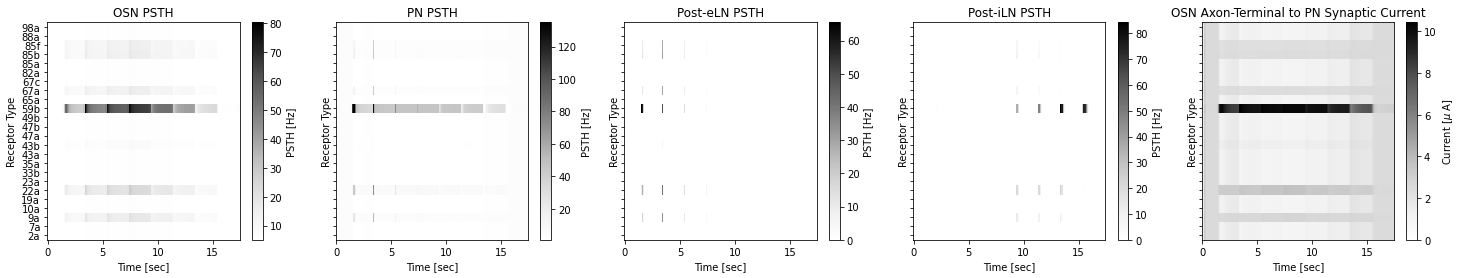

In [268]:
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')
fig.savefig('figures/ant_al_io_acetone.pdf')

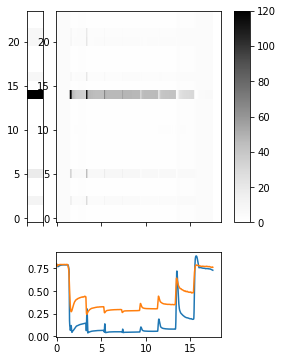

In [84]:
%matplotlib inline
from antennal_lobe.experiments.metrics import ang_dist 
fig,axes = plt.subplots(2,3,figsize=(4,6), sharex='col', gridspec_kw=dict(width_ratios=[1,10,1], height_ratios=[5,2]))
axes[0,0].pcolormesh(
    [0, 1], np.arange(-.5, N_r), aff[:,None],
    rasterized=True,
    cmap=plt.cm.Greys
)

cax = axes[0,1].pcolormesh(
    t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, 
    shading='nearest', rasterized=True,
    cmap=plt.cm.Greys, vmin=0, vmax=120
)
plt.colorbar(cax, cax=axes[0,2])
axes[1,1].plot(t, ang_dist(nn_rate.containers['PN-BSG'].recorder.x.T, aff[None,:]))
axes[1,1].plot(t, ang_dist(nn_rate.containers['OSN-BSG'].recorder.x.T, aff[None,:]))
axes[1,0].remove()
axes[1,-1].remove()
fig.savefig('acetone_pn.pdf')

Text(0.5, 1.0, 'SNR 10.32 dB')

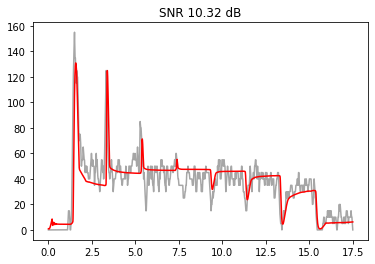

In [260]:
plt.plot(t, pn, c='grey', alpha=.7)
plt.plot(t, pn_bsg.recorder.x[14]/dt, c='r')
plt.title(f"SNR {snr(pn,pn-pn_bsg.recorder.x[14]/dt, dt):.2f} dB")

In [153]:
%matplotlib widget
fig,ax = plt.subplots(1,1,figsize=(8,8),subplot_kw=dict(projection='3d'))
norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 30):
    if I in lc_clean:
        v,n =lc_clean[I]['v'], lc_clean[I]['n']
        ax.plot(v, n, np.ones_like(v)*I, c=plt.cm.coolwarm(norm(I)), lw=4)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'], lc_noisy[I]['n']
        ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=plt.cm.coolwarm(norm(I)), lw=4)

ax.set(zticks=[0,9,20,30])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.view_init(azim=-31, elev=18)
fig.savefig('lc_mountain_combined.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [281]:
x1_14 = nn_rate.containers['PN-BSG'].recorder.x[14]
x2_14 = nn_rate.containers['PN-BSG'].recorder.x[14]
x1_10 = nn_rate_2.containers['PN-BSG'].recorder.x[10]
x2_10 = nn_rate_2.containers['PN-BSG'].recorder.x[10]

In [287]:

x1_14 = nn_rate.containers['PN-BSG'].recorder.x[14]
I1_14 = nn_rate.containers['PN-Dendrite'].recorder.output[14]
x1_10 = nn_rate.containers['PN-BSG'].recorder.x[10]
I1_10 = nn_rate.containers['PN-Dendrite'].recorder.output[10]
x2_14 = nn_rate_2.containers['PN-BSG'].recorder.x[14]
I2_14 = nn_rate_2.containers['PN-Dendrite'].recorder.output[14]
x2_10 = nn_rate_2.containers['PN-BSG'].recorder.x[10]
I2_10 = nn_rate_2.containers['PN-Dendrite'].recorder.output[10]
np.savez(
    '2channel_data', 
    x=np.vstack([x1_14,x1_10,x2_14,x2_10]),
    I=np.vstack([I1_14,I1_10,I2_14,I2_10]),
)

In [275]:
%matplotlib widget
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()
fig,ax = plt.subplots(1,1,figsize=(8,8),subplot_kw=dict(projection='3d'))
norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 30):
    if I in lc_clean:
        v,n =lc_clean[I]['v'], lc_clean[I]['n']
        ax.plot(v, n, np.ones_like(v)*I, c='grey', alpha=.5)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'], lc_noisy[I]['n']
        ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c='grey', alpha=.5)

ax.plot()

ax.set(zticks=[0,9,20,30])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.view_init(azim=-31, elev=18)

nn.containers['PN-BSG'].recorder.x[14]
# fig.savefig('lc_mountain_combined.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [171]:
%matplotlib widget
index = [0, 5, 10, 14, 20, 23]
fig,axes = plt.subplots(2,len(index),figsize=(15,6), subplot_kw=dict(projection='3d'))
for n,i in enumerate(index):
    _, I_all,_,_ = decompose_signal(t, stim[None,:], nn_rate.containers['PN-Dendrite'].recorder.output[[i]])
    I1 = np.round(np.mean(I_all))
    _, I_all,_,_ = decompose_signal(t, stim[None,:], nn_rate_2.containers['PN-Dendrite'].recorder.output[[i]])
    I2 = np.round(np.mean(I_all))
    for I in range(15):
        if I in lc_clean:
            lc = lc_clean
            lc_v=lc[I]['v']
            lc_n=lc[I]['n']
            c = 'red'
        elif I in lc_noisy:
            lc = lc_noisy
            lc_v=lc[I]['v'].data[~lc[I]['v'].mask]
            lc_n=lc[I]['n'].data[~lc[I]['n'].mask]
            c = 'blue'
        else:
            continue
        if I in lc:
            axes[0,n].plot(
                lc_v,
                lc_n,
                np.ones_like(lc_v)*I, 
                c='grey' if I != I1 else c,
                alpha=.5  if I != I1 else 1,
                lw=1   if I != I1 else 2
            )
            axes[1,n].plot(
                lc_v, 
                lc_n, 
                np.ones_like(lc_v)*I, 
                c='grey' if I != I2 else c,
                alpha=.5  if I != I2 else 1,
                lw=1   if I != I2 else 2
            )
            axes[0,n].view_init(azim=-18, elev=31)
            axes[1,n].view_init(azim=-18, elev=31)
for ax in axes.ravel():
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
# fig.savefig('3d_comparison_clean.pdf')
# fig.savefig('lcs_comparison.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [68]:
snr(pn, pn-estimate_spike_rate(.3*osn_axt_to_pn.recorder.I + posteln_to_pn.recorder.I + 1.9*postiln_to_pn.recorder.I, resting=1)[14], dt)

10.300228912143428

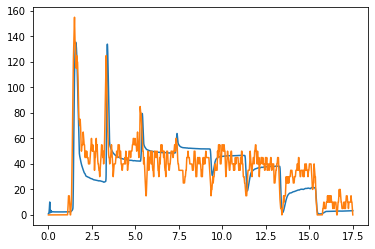

In [76]:
plt.plot(t, pn_bsg.recorder.x[14]/dt)
plt.plot(t, pn)

In [73]:
snr(pn, pn-pn_bsg.recorder.x[14]/dt, dt)

8.850130056836495

10.300228912143428

(0.0, 0.4)

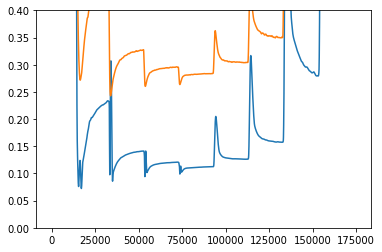

In [59]:
plt.plot(ang_dist(
    estimate_spike_rate(.3*osn_axt_to_pn.recorder.I + posteln_to_pn.recorder.I + 1.9*postiln_to_pn.recorder.I, resting=1).T,
    aff[None,:]
))

plt.plot(ang_dist(
    osn_bsg.recorder.x.T,
    aff[None,:]
))
plt.ylim([0,.4])

(0.0, 0.4)

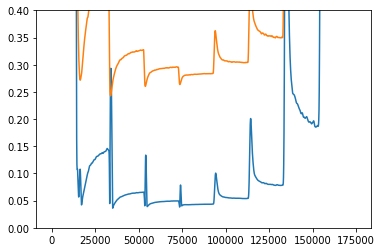

In [54]:
plt.plot(ang_dist(
    pn_bsg.recorder.x.T,
    aff[None,:]
))

plt.plot(ang_dist(
    osn_bsg.recorder.x.T,
    aff[None,:]
))
plt.ylim([0,.4])

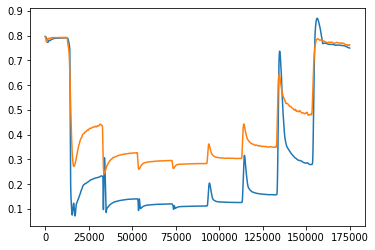

In [48]:
plt.plot(ang_dist(
    estimate_spike_rate(.3*osn_axt_to_pn.recorder.I + posteln_to_pn.recorder.I + 1.9*postiln_to_pn.recorder.I, resting=1).T,
    aff[None,:]
))

plt.plot(ang_dist(
    osn_bsg.recorder.x.T,
    aff[None,:]
))

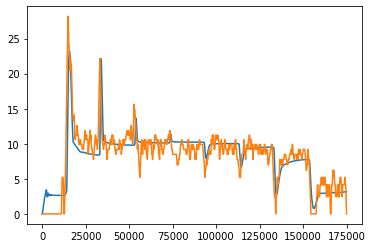

In [40]:
plt.plot(.3*osn_axt_to_pn.recorder.I[14] + posteln_to_pn.recorder.I[14] + 1.9*postiln_to_pn.recorder.I[14])
plt.plot(estimate_current(pn, resting=1))

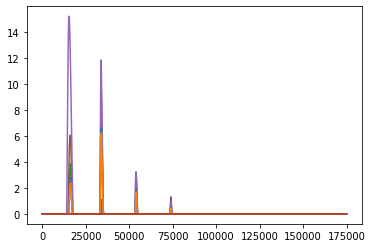

In [21]:
posteln_to_pn.recorder.I.T

In [73]:
from scipy.io import savemat
savemat('example_io_spatiotemporal.mat', dict(
    on=posteln_to_pn.recorder.I,
    off=postiln_to_pn.recorder.I,
    axt=osn_axt_to_pn.recorder.I,
    pn=pn_bsg.recorder.x,
    t=t,
    aff=aff,
))

In [ ]:
from matplotlib.gridspec import GridSpec

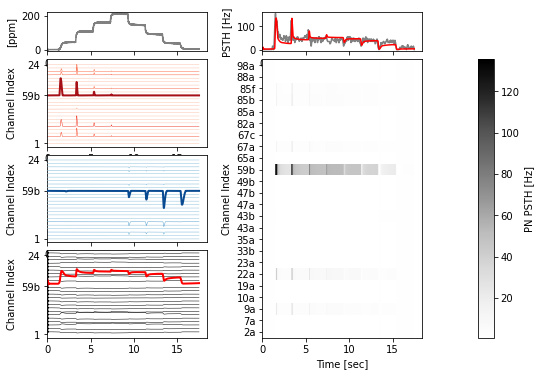

In [170]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = GridSpec(7,3, figure=fig, width_ratios=[10,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt = (    
    fig.add_subplot(gs[1:3,0], sharex=ax_inp),
    fig.add_subplot(gs[3:5,0], sharex=ax_inp),
    fig.add_subplot(gs[5:7,0], sharex=ax_inp),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,2])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t, stim, c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    y_axt = 5*axt / np.abs(axt_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t, np.ones_like(t)*i + y_on, c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t, np.ones_like(t)*i + y_off, c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
    _ = ax_axt.plot(t, np.ones_like(t)*i + y_axt, c='k' if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
ax_dm4.plot(t, pn, c='grey')
ax_dm4.plot(t, nn_rate.containers['PN-BSG'].recorder.x[14]/dt, c='r')
cax = ax_pn.pcolormesh(t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
fig.savefig('new_spatiotemporal_io.pdf')

In [158]:
from matplotlib.gridspec import GridSpec

In [159]:
%matplotlib widget
fig = plt.figure(figsize=(8,6))
gs = GridSpec(5,4, figure=fig, width_ratios=[10, 1,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt, ax_axt_cbar = (    
    fig.add_subplot(gs[1,0], sharex=ax_inp, projection='3d'),
    fig.add_subplot(gs[2,0], sharex=ax_inp, projection='3d'),
    fig.add_subplot(gs[3:,0], sharex=ax_inp),
    fig.add_subplot(gs[3:,1]),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,2], sharex=ax_inp),
    fig.add_subplot(gs[3:,2], sharex=ax_inp),
    fig.add_subplot(gs[3:,3])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t, stim, c='grey')
ax_inp.set(ylabel='[ppm]')
for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on =on# / np.abs(on_all).max()
    y_off = off# / np.abs(on_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t, np.ones_like(t)*i, y_on, c=plt.cm.Reds(np.abs(on).max()/np.abs(on_all).max())) #plt.cm.Reds(.1) if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t, np.ones_like(t)*i, y_off, c=plt.cm.Blues(np.abs(off).max()/np.abs(off_all).max())) #plt.cm.Blues(.1) if i != 14 else 'b', zorder=-i, lw=.5 if i!=14 else 2)

ax_dm4.plot(t, stim, c='grey')
cax = ax_axt.pcolormesh(t[::100], np.arange(N_r), axt_all[:,::100], cmap=plt.cm.Greys, shading='nearest', rasterized=True)
plt.colorbar(cax, cax=ax_axt_cbar, label='Synaptic Current [$\mu A$]')
cax = ax_pn.pcolormesh(t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
# fig.savefig('new_spatiotemporal_io.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [160]:
%matplotlib widget
fig,axes = plt.subplots(1,2,figsize=(12,3), sharey=True, sharex=True, subplot_kw=dict(projection='3d'))
on_all = nn_rate.containers['Post-eLN'].recorder.x
off_all = nn_rate.containers['Post-iLN'].recorder.x
colors = plt.cm.get_cmap('viridis', N_r)
for i, (on,off) in enumerate(zip(on_all, off_all)):
    y_on = on
    y_off = off
    # c = plt.cm.coolwarm()
    _ = axes[0].plot(t, np.ones_like(t)*i, y_on, c=colors(i))
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = axes[1].plot(t, np.ones_like(t)*i, y_off, c=colors(i))
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
axes[0].set_aspect('auto')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Ethyl Acetatte

In [269]:
# np.savez('osn_inp', osn=nn_rate.containers['OSN-BSG'].recorder.x)

In [270]:
nn_rate_2 = Network(solver="euler")
inp = nn_rate_2.input(num=1, name='stim')
inp_repeat = nn_rate_2.add(Repeat, num=1, rep_size=N_r, name='stim-rep')
osn_otp = nn_rate_2.add(OTP, num=N_r, br=dr*aff2, dr=dr, name='OSN-OTP')
osn_bsg = nn_rate_2.add(PoissonCSN, num=N_r, name='OSN-BSG')

osn_axt = nn_rate_2.add(dDNP, num=N_r, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn_rate_2.add(IonSyn, num=N_r, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn_rate_2.add(PreLN, num=N_r, operation='norm-2', block_size=N_r, name="Pre-LN Input")
preln = nn_rate_2.add(PoissonCSN0, num=N_r, name="Pre-LN")
osn_axt_to_pn = nn_rate_2.add(IonSyn, num=N_r, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn_rate_2.add(PostLNSyn, num=N_r, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn_rate_2.add(PoissonCSN0, num=N_r, name="Post-eLN")
posteln_to_pn = nn_rate_2.add(IonSyn, num=N_r, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn_rate_2.add(PostLNSyn, num=N_r, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn_rate_2.add(PoissonCSN0, num=N_r, name="Post-iLN")
postiln_to_pn = nn_rate_2.add(IonSyn, num=N_r, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn_rate_2.add(Add, num=N_r, name='PN-Dendrite')
pn_bsg = nn_rate_2.add(PoissonCSN1, num=N_r, name='PN-BSG')

inp_repeat(input=inp)
osn_otp(stimulus=inp_repeat.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.x, l=preln.x)

preln_syn(u=osn_axt.x1)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)
osn_axt_to_pn(u=osn_axt.x1)

posteln_syn(u=osn_bsg.x)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.x)

postiln_syn(u=osn_bsg.x)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.x)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn_rate_2.compile(dtype=float, backend="cuda")

osn_bsg.record('x')
posteln.record('x')
postiln.record('x')
posteln_syn.record('x1','I')
postiln_syn.record('x1','I')

posteln_to_pn.record('I')
postiln_to_pn.record('I')

osn_axt.record('x1')
osn_axt_to_pn.record('I')
preln.record('x')
pn_bsg.record('x')
pn_inp.record('output')

Load input signal to the network instance

In [271]:
inp_g = garray.to_gpu(np.ascontiguousarray(stim))
inp(inp_g)

Run Network

In [272]:
nn_rate_2.run(dt, verbose=True)

  0%|          | 0/175000 [00:00<?, ?it/s]

Plot Model I/O

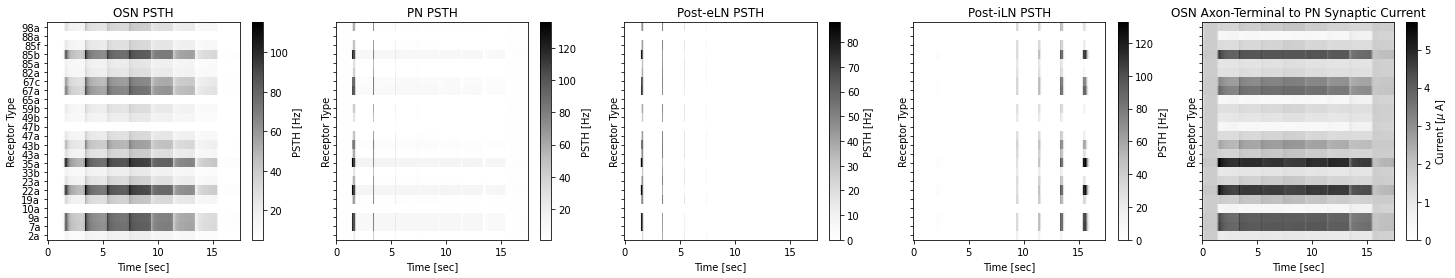

In [431]:
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')
fig.savefig('ant_al_io_1_pentanol.pdf')

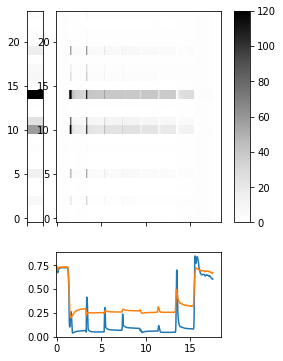

In [256]:
%matplotlib inline
from antennal_lobe.experiments.metrics import ang_dist 
fig,axes = plt.subplots(2,3,figsize=(4,6), sharex='col', gridspec_kw=dict(width_ratios=[1,10,1], height_ratios=[5,2]))
axes[0,0].pcolormesh(
    [0, 1], np.arange(-.5, N_r), aff2[:,None],
    rasterized=True,
    cmap=plt.cm.Greys
)

cax = axes[0,1].pcolormesh(
    t[::100], np.arange(N_r), nn_rate_2.containers['PN-BSG'].recorder.x[:,::100]/dt, 
    shading='nearest', rasterized=True,
    cmap=plt.cm.Greys, vmin=0, vmax=120
)
plt.colorbar(cax, cax=axes[0,2])
axes[1,1].plot(t, ang_dist(nn_rate_2.containers['PN-BSG'].recorder.x.T, aff2[None,:]))
axes[1,1].plot(t, ang_dist(nn_rate_2.containers['OSN-BSG'].recorder.x.T, aff2[None,:]))
axes[1,0].remove()
axes[1,-1].remove()
fig.savefig('ethyl_acetate_pn.pdf')

In [320]:
lc = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()

In [155]:
from antennal_lobe.experiments.data import decompose_signal

In [170]:
%matplotlib widget
index = [0, 5, 10, 14, 20, 23]
fig,axes = plt.subplots(2,len(index),figsize=(15,6), subplot_kw=dict(projection='3d'))
for n,i in enumerate(index):
    _, I_all,_,_ = decompose_signal(t, stim[None,:], nn_rate_2.containers['PN-Dendrite'].recorder.output[[i]])
    I1 = np.round(np.mean(I_all))
    _, I_all,_,_ = decompose_signal(t, stim[None,:], nn_rate_2.containers['PN-Dendrite'].recorder.output[[i]])
    I2 = np.round(np.mean(I_all))
    for I in range(15):
        if I in lc:
            axes[0,n].plot(
                lc[I]['v'].data[~lc[I]['v'].mask], 
                lc[I]['n'].data[~lc[I]['n'].mask], 
                np.ones_like(lc[I]['v'].data[~lc[I]['v'].mask])*I, 
                c='grey' if I != I1 else 'r',
                alpha=.5  if I != I1 else 1,
                lw=1   if I != I1 else 2
            )
            axes[1,n].plot(
                lc[I]['v'].data[~lc[I]['v'].mask], 
                lc[I]['n'].data[~lc[I]['n'].mask], 
                np.ones_like(lc[I]['v'].data[~lc[I]['v'].mask])*I, 
                c='grey' if I != I2 else 'r',
                alpha=.5  if I != I2 else 1,
                lw=1   if I != I2 else 2
            )
            axes[0,n].view_init(azim=-18, elev=31)
            axes[1,n].view_init(azim=-18, elev=31)
for ax in axes.ravel():
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
# fig.savefig('3d_comparison_clean.pdf')
# fig.savefig('lcs_comparison.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

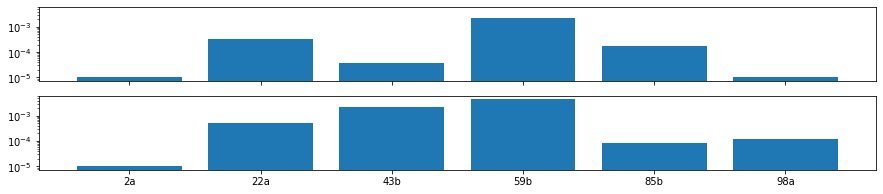

In [343]:
%matplotlib inline
index = [0, 5, 10, 14, 20, 23]
fig,axes = plt.subplots(2,1,figsize=(15,3), sharex=True, sharey=True)
axes[0].bar(np.arange(len(index)), aff[index])
axes[1].bar(np.arange(len(index)), aff2[index])
axes[1].set(xticks=np.arange(len(index)), xticklabels=df_aff.columns[index])
_ = [ax.set(yscale='log') for ax in axes]
fig.savefig('affinities_comparison.pdf')

In [259]:
np.argsort(aff)
np.argsort(aff2)

array([ 0,  1,  3,  4,  6,  9, 22, 12, 15,  7, 13, 18, 20,  8, 21, 23, 17,
        2, 16,  5, 19, 11, 10, 14])

## Spiking Model

In [ ]:
N_osns = 10
N_pns = 5

In [ ]:
nn_spike = Network(solver="euler")
inp = nn_spike.input(num=1, name='stim')
inp_repeat = nn_spike.add(Repeat, num=1, rep_size=N_r, name='stim-rep')
osn_otp = nn_spike.add(OTP, num=N_r, br=dr*aff, dr=dr, name='OSN-OTP')
osn_inp = nn_spike.add(Repeat, 
osn_bsg = nn_spike.add(NoisyConnorStevens, num=N_r*N_osns, name='OSN-BSG', sigma=params['osn_bsg']['sigma']/np.sqrt(dt))

osn_axt = nn_spike.add(dDNP, num=N_r, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn_spike.add(IonSyn, num=N_r, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn_spike.add(PreLN, num=N_r, operation='sum', block_size=N_r, name="Pre-LN Input")
preln = nn_spike.add(NoisyConnorStevens, num=N_r, name="Pre-LN", sigma=params['preln_bsg']['sigma']/np.sqrt(dt))
osn_axt_to_pn = nn_spike.add(IonSyn, num=N_r, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn_spike.add(PostLNSyn, num=N_r, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn_spike.add(NoisyConnorStevens, num=N_r, name="Post-eLN", sigma=params['posteln_bsg']['sigma']/np.sqrt(dt))
posteln_to_pn = nn_spike.add(IonSyn, num=N_r, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn_spike.add(PostLNSyn, num=N_r, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn_spike.add(NoisyConnorStevens, num=N_r, name="Post-iLN", sigma=params['postiln_bsg']['sigma']/np.sqrt(dt))
postiln_to_pn = nn_spike.add(IonSyn, num=N_r, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn_spike.add(Add, num=N_r, name='PN-Dendrite')
pn_bsg = nn_spike.add(NoisyConnorStevens, num=N_r, name='PN-BSG', sigma=params['pn_bsg']['sigma']/np.sqrt(dt))

inp_repeat(input=inp)
osn_otp(stimulus=inp_repeat.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.spike, l=preln.spike)
osn_axt_to_pn(u=osn_axt.x1)

preln_syn(u=osn_bsg.spike)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)

posteln_syn(u=osn_bsg.spike)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.spike)

postiln_syn(u=osn_bsg.spike)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.spike)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn_spike.compile(dtype=float, backend="cuda")

osn_bsg.record('spike')
posteln.record('spike')
postiln.record('spike')
posteln_syn.record('x1','I')
postiln_syn.record('x1','I')

posteln_to_pn.record('I')
postiln_to_pn.record('I')

osn_axt.record('x1')
osn_axt_to_pn.record('x1', 'I')
preln.record('spike')
pn_bsg.record('spike')
pn_inp.record('output')

Load input signal to the network instance

In [ ]:
inp_g = garray.to_gpu(np.ascontiguousarray(stim))
inp(inp_g)

Run Network

In [ ]:
nn_spike.run(dt, verbose=True)

  0%|          | 0/175000 [00:00<?, ?it/s]

Plot Model I/O

In [ ]:
def plot_spike(ax, spike, t):
    t_idx, neu_idx = np.nonzero(spike)
    ax.plot(t[t_idx], neu_idx, '|')

[Text(0.5, 1.0, 'PreLN Spikes'),
 Text(0.5, 0, 'Time [sec]'),
 Text(0, 0.5, 'Receptor Type')]

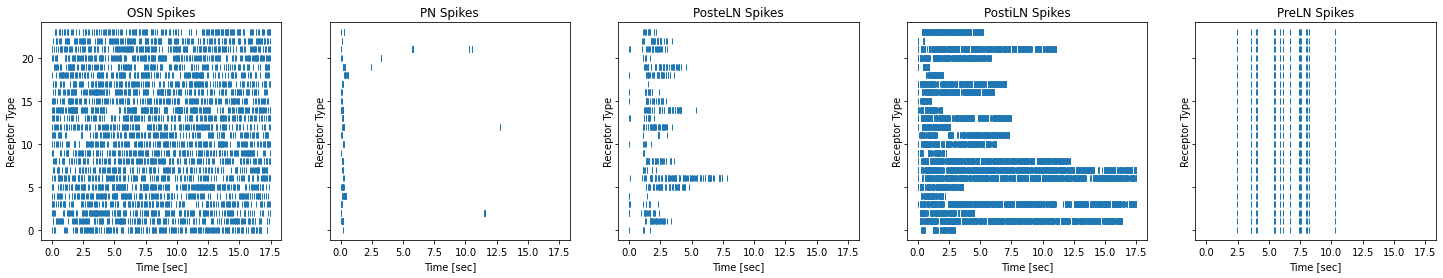

In [ ]:
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
# cax = axes[0].pcolormesh(
#     t[::ds],
#     df_aff.columns,
#     osn_bsg.recorder.spike[:,::ds]/dt,
#     shading='nearest',
#     cmap=cmap,
#     rasterized=True
# )
# plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
plot_spike(axes[0], osn_bsg.recorder.spike.T, t)
axes[0].set(title='OSN Spikes', xlabel='Time [sec]', ylabel='Receptor Type')

plot_spike(axes[1], pn_bsg.recorder.spike.T, t)
axes[1].set(title='PN Spikes', xlabel='Time [sec]', ylabel='Receptor Type')

plot_spike(axes[2], posteln.recorder.spike.T, t)
axes[2].set(title='PosteLN Spikes', xlabel='Time [sec]', ylabel='Receptor Type')

plot_spike(axes[3], postiln.recorder.spike.T, t)
axes[3].set(title='PostiLN Spikes', xlabel='Time [sec]', ylabel='Receptor Type')

plot_spike(axes[4], preln.recorder.spike.T, t)
axes[4].set(title='PreLN Spikes', xlabel='Time [sec]', ylabel='Receptor Type')


# cax = axes[1].pcolormesh(
#     t[::ds],
#     df_aff.columns,
#     pn_bsg.recorder.x[:,::ds]/dt,
#     shading='nearest',
#     cmap=cmap,
#     rasterized=True
# )
# plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
# axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
# cax = axes[2].pcolormesh(
#     t[::ds],
#     df_aff.columns,
#     posteln.recorder.x[:,::ds]/dt,
#     shading='nearest',
#     cmap=cmap,
#     rasterized=True
# )
# plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
# axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
# cax = axes[3].pcolormesh(
#     t[::ds],
#     df_aff.columns,
#     postiln.recorder.x[:,::ds]/dt,
#     shading='nearest',
#     cmap=cmap,
#     rasterized=True
# )
# plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
# axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
# cax = axes[4].pcolormesh(
#     t[::ds],
#     df_aff.columns,
#     osn_axt_to_pn.recorder.I[:,::ds],
#     shading='nearest',
#     cmap=cmap,
#     rasterized=True
# )
# plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
# _ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')
# fig.savefig('ant_al_io.pdf')

[Text(0.5, 1.0, 'OSN PSTH'),
 Text(0.5, 0, 'Time [sec]'),
 Text(0, 0.5, 'Receptor Type')]

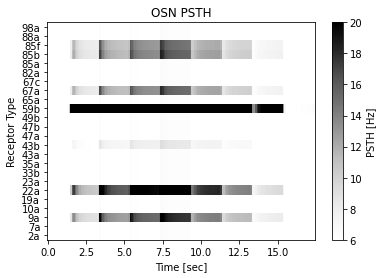

In [ ]:
fig,ax = plt.subplots(1,1)
cax=ax.pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    vmin=6,
    vmax=20
)
plt.colorbar(cax, ax=ax,label='PSTH [Hz]')
ax.set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

In [206]:
np.savez('pn_inp', I=nn_rate.containers['PN-Dendrite'].recorder.output, t=t)

## Computing Objective Function

In [12]:
import neural.plot as nplt
import typing as tp
from scipy.signal import find_peaks, butter, lfilter

def decompose_signal(
    t, stim, out, rec_rate=1, t_bounds=None, axis=-1, contrast_eps=1.0, ss_window=0.5, clip=True
) -> tp.Tuple["ss", "pk"]:
    dt = t[1] - t[0]
    b, a = butter(5, 15, fs=1 / dt)
    stim_smooth = lfilter(b, a, np.clip(stim, 0, np.inf), axis=axis)
    d_stim = np.diff(stim_smooth, axis=axis, prepend=stim_smooth[:, [0]]) / dt
    contrast_stim = d_stim / (contrast_eps + stim_smooth)
    pos_peaks_contrast = np.sort(
        np.concatenate(
            [
                find_peaks(
                    contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
                find_peaks(
                    -contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
            ]
        )
    )
    pos_peaks_contrast = (pos_peaks_contrast// rec_rate).astype(int)
    ss = np.zeros_like(out)
    ss[:, : pos_peaks_contrast[0]] = 0  # out[:,:pos_peaks_contrast[0]].mean(1)[:,None]
    ss[
        :, pos_peaks_contrast[-1] :
    ] = 0  # out[:,pos_peaks_contrast[-1]:].mean(1)[:,None]
    ss_vals = np.zeros((out.shape[0], len(pos_peaks_contrast) - 1))
    for n, (start_idx, stop_idx) in enumerate(
        zip(pos_peaks_contrast[:-1], pos_peaks_contrast[1:])
    ):
        ss_amp = out[
            :,
            stop_idx
            - int((0.2 + ss_window) // (dt * rec_rate)) : stop_idx
            - int(0.2 // (dt * rec_rate)),
        ].mean(axis=1)
        ss_vals[:, n] = ss_amp
        ss[:, start_idx:stop_idx] = ss_amp[:, None]
    pk = out - ss
    # trim the peak responses
    if clip:
        pk[:, t[::rec_rate]<=11.83] = np.clip(pk[:, t[::rec_rate]<=11.83], 0, np.inf)
        pk[:, t[::rec_rate]>11.83] = np.clip(pk[:, t[::rec_rate]>11.83], -np.inf, 0)

    # add residual back to ss so that we still add up to the overall response
    ss = out - pk

    return pos_peaks_contrast, ss_vals, ss, pk

In [13]:
jump_times, _, pn_ss, pn_pk = decompose_signal(t, stim[None,:], data['pn_output'][2][None,:])
_, _, pn_ss_flat, _ = decompose_signal(t, stim[None,:], data['pn_output'][2][None,:], clip=False)
jump_times, pn_model_ss_amp, pn_model_ss, pn_model_pk = decompose_signal(t, stim[None,:], pn_bsg.recorder.x, clip=False)

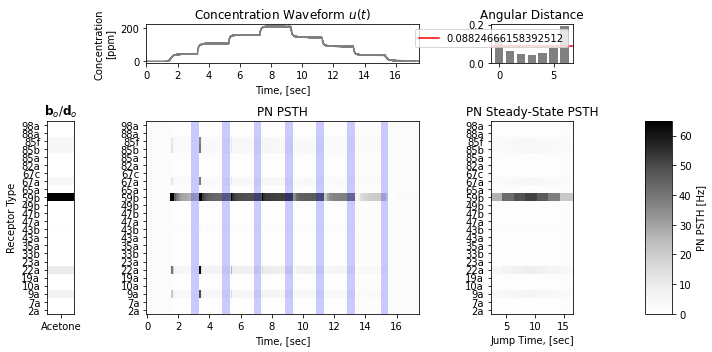

In [14]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
# Loop over data points; create box from errors at each point
ss_windows = [
    Rectangle((j*dt-.5, -.5), .5, N_r)
    for j in jump_times[1:]
]

# # Create patch collection with specified colour/alpha
pc = PatchCollection(ss_windows, facecolor='blue', alpha=.2, edgecolor='none')

fig,axes = plt.subplots(2,4,figsize=(10,5),gridspec_kw=dict(width_ratios=[1,10,3,1], height_ratios=[2,10]))
ax_aff, ax_pn, ax_pn_ss, ax_pn_cbar = axes[1]
axes[0,1].plot(t, stim, color='gray')
ax_aff.pcolormesh(*np.meshgrid([-.5,.5], np.arange(-.5, N_r+.5)), aff[:,None], cmap=cmap, rasterized=True)
cax = nplt.plot_mat(pn_bsg.recorder.x[:,::1000] / dt, t=t[::1000], ax=ax_pn, cax=ax_pn_cbar, cbar_kw=dict(label='PN PSTH [Hz]'), cmap=cmap, vmin=0, vmax=65, rasterized=True, shading='nearest')
nplt.plot_mat(pn_model_ss_amp / dt, t=np.round(jump_times[1:]*dt, 1), ax=ax_pn_ss, cax=None, cmap=cmap, vmin=0, vmax=65, rasterized=True, shading='nearest')
axes[0,0].remove()
axes[0,-1].remove()
_ = ax_aff.set(
    ylim=[-.5, N_r-.5], yticks=np.arange(N_r), yticklabels=df_aff.columns, xticks=[0],
    xticklabels=["Acetone"], 
    title=r"${\bf b}_o/{\bf d}_o$",
    ylabel="Receptor Type"
)
_ = ax_pn.set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Time, [sec]", title="PN PSTH")
_ = ax_pn_ss.set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Jump Time, [sec]", 
    title="PN Steady-State PSTH"
)

from antennal_lobe.experiments.metrics import ang_dist

ax_pn.add_collection(pc)
_ = axes[0,1].set(xlabel='Time, [sec]', ylabel='Concentration\n[ppm]', title='Concentration Waveform $u(t)$', xlim=[min(t), max(t)])

axes[0,2].bar(np.arange(len(jump_times[1:])), ang_dist(pn_model_ss_amp.T, aff[None,:]), color='gray')
axes[0,2].axhline(ang_dist(pn_model_ss_amp.T, aff[None,:]).mean(), color='r', label=f'{ang_dist(pn_model_ss_amp.T, aff[None,:]).mean()}')
axes[0,2].legend()
axes[0,2].set(title='Angular Distance')
fig.tight_layout()
fig.savefig("spatio_metric_example.pdf")

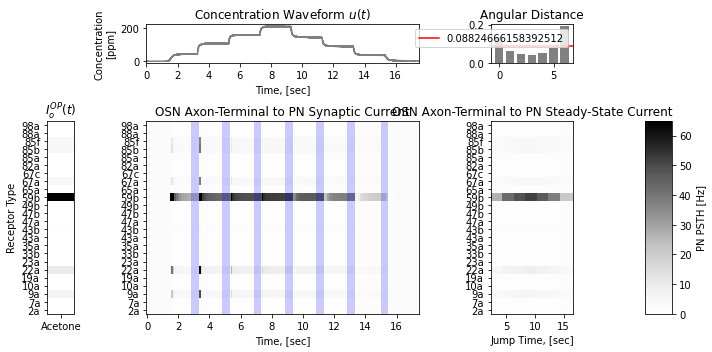

In [15]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
# Loop over data points; create box from errors at each point
ss_windows = [
    Rectangle((j*dt-.5, -.5), .5, N_r)
    for j in jump_times[1:]
]

# # Create patch collection with specified colour/alpha
pc = PatchCollection(ss_windows, facecolor='blue', alpha=.2, edgecolor='none')

fig,axes = plt.subplots(2,4,figsize=(10,5),gridspec_kw=dict(width_ratios=[1,10,3,1], height_ratios=[2,10]))
ax_aff, ax_pn, ax_pn_ss, ax_pn_cbar = axes[1]
axes[0,1].plot(t, stim, color='gray')
ax_aff.pcolormesh(
    *np.meshgrid([-.5,.5], np.arange(-.5, N_r+.5)), 
    aff[:,None], cmap=cmap, rasterized=True
)
cax = nplt.plot_mat(pn_bsg.recorder.x[:,::1000] / dt, t=t[::1000], ax=ax_pn, cax=ax_pn_cbar, cbar_kw=dict(label='PN PSTH [Hz]'), cmap=cmap, vmin=0, vmax=65, rasterized=True, shading='nearest')
nplt.plot_mat(pn_model_ss_amp / dt, t=np.round(jump_times[1:]*dt, 1), ax=ax_pn_ss, cax=None, cmap=cmap, vmin=0, vmax=65, rasterized=True, shading='nearest')
axes[0,0].remove()
axes[0,-1].remove()
_ = ax_aff.set(
    ylim=[-.5, N_r-.5], yticks=np.arange(N_r), yticklabels=df_aff.columns, xticks=[0],
    xticklabels=["Acetone"], 
    title="$I^{OP}_o(t)$",
    ylabel="Receptor Type"
)
_ = ax_pn.set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Time, [sec]", title="OSN Axon-Terminal to PN Synaptic Current")
_ = ax_pn_ss.set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Jump Time, [sec]", 
    title="OSN Axon-Terminal to PN Steady-State Current"
)

from antennal_lobe.experiments.metrics import ang_dist

ax_pn.add_collection(pc)
_ = axes[0,1].set(xlabel='Time, [sec]', ylabel='Concentration\n[ppm]', title='Concentration Waveform $u(t)$', xlim=[min(t), max(t)])

axes[0,2].bar(np.arange(len(jump_times[1:])), ang_dist(pn_model_ss_amp.T, aff[None,:]), color='gray')
axes[0,2].axhline(ang_dist(pn_model_ss_amp.T, aff[None,:]).mean(), color='r', label=f'{ang_dist(pn_model_ss_amp.T, aff[None,:]).mean()}')
axes[0,2].legend()
axes[0,2].set(title='Angular Distance')
fig.tight_layout()
fig.savefig("spatio_metric_example_current.pdf")

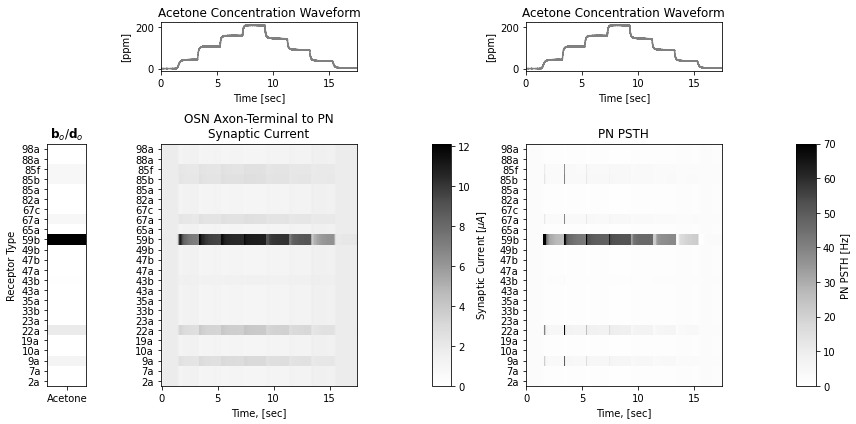

In [16]:
fig,axes=plt.subplots(2,5,figsize=(12,6),gridspec_kw=dict(width_ratios=[2,10,1,10,1], height_ratios=[2,10]))
axes[0,1].plot(t, stim, c='gray')
axes[0,3].plot(t, stim, c='gray')
axes[1,0].pcolormesh(
    *np.meshgrid([-.5,.5], np.arange(-.5, N_r+.5)), aff[:,None], 
    cmap=cmap, rasterized=True
)
cax = nplt.plot_mat(
    osn_axt_to_pn.recorder.I[:,::1000], t=t[::1000], ax=axes[1,1], 
    cax=axes[1,2], cbar_kw=dict(label='Synaptic Current [$\mu A$]'), cmap=cmap, 
    vmin=0, rasterized=True, shading='nearest'
)
cax = nplt.plot_mat(
    pn_bsg.recorder.x[:,::1000]/dt, t=t[::1000], ax=axes[1,3], 
    vmin=0, vmax=70,
    cax=axes[1,4], cbar_kw=dict(label='PN PSTH [Hz]'), cmap=cmap, 
    rasterized=True, shading='nearest'
)
axes[0,0].remove()
axes[0,2].remove()
axes[0,-1].remove()

_ = axes[1,0].set(
    ylim=[-.5, N_r-.5], yticks=np.arange(N_r), yticklabels=df_aff.columns, xticks=[0],
    xticklabels=["Acetone"], 
    title=r"${\bf b}_o/{\bf d}_o$",
    ylabel="Receptor Type"
)
_ = axes[1,1].set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Time, [sec]", 
    title="OSN Axon-Terminal to PN\nSynaptic Current")

_ = axes[1,3].set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Time, [sec]", 
    title="PN PSTH")
axes[0,1].set(
    xlabel='Time [sec]', ylabel='[ppm]', title='Acetone Concentration Waveform', 
    xlim=[min(t), max(t)]
)
axes[0,3].set(
    xlabel='Time [sec]', ylabel='[ppm]', title='Acetone Concentration Waveform', 
    xlim=[min(t), max(t)]
)
fig.tight_layout()
fig.savefig('osn_axt_spatio_temporal_io.pdf')

In [17]:
ss_I = np.load('tmp.npz')['ss_I']
ss_I_flat = np.load('tmp.npz')['ss_I_flat']
t2 = np.load('tmp.npz')['t']
t_mask = np.logical_and(t2>=2.5, t2<20.)
ss_I = ss_I[:,t_mask]
ss_I_flat = ss_I_flat[:,t_mask]

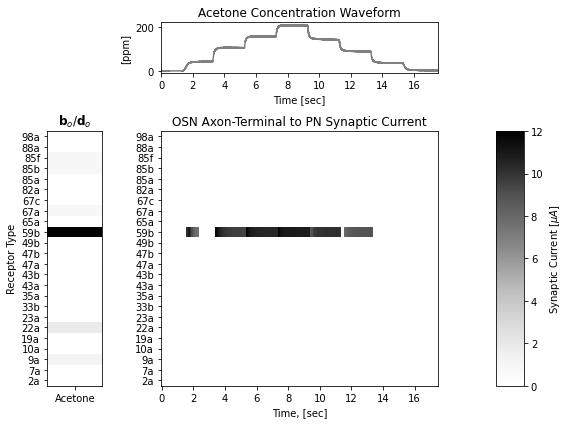

In [18]:
fig,axes=plt.subplots(2,3,figsize=(8,6),gridspec_kw=dict(width_ratios=[2,10,1], height_ratios=[2,10]))
_data_to_plot = osn_axt_to_pn.recorder.I
_data_to_plot[_data_to_plot<7.6] =0.
_title = "OSN Axon-Terminal to PN Synaptic Current"
_cbar_label = "Synaptic Current [$\mu A$]"
_fname = "osn_axt_spatiotemporal_io.pdf"
# _data_to_plot = pn_bsg.recorder.x / dt #np.outer((aff/aff.max()), pn)
# _data_to_plot = np.outer(aff/aff.max(), ss_I[0])
# _title = "OSN Axon-Terminal Reference Synaptic Current "
# _cbar_label = "Synaptic Current [$\mu A$]"
# _fname = "osn_axt_spatiotemporal_io_ref.pdf"
_vmin, _vmax = 0, 12

_ds = 1000
axes[0,1].plot(t, stim, c='gray')
axes[1,0].pcolormesh(
    *np.meshgrid([-.5,.5], np.arange(-.5, N_r+.5)), aff[:,None], 
    cmap=cmap, rasterized=True
)
cax = nplt.plot_mat(
    _data_to_plot[:,::_ds], t=t[::_ds], ax=axes[1,1], 
    cax=axes[1,2], cbar_kw=dict(label=_cbar_label), cmap=cmap, 
    vmin=_vmin, vmax=_vmax, rasterized=True, shading='nearest'
)

_ = axes[1,0].set(
    ylim=[-.5, N_r-.5], yticks=np.arange(N_r), yticklabels=df_aff.columns, xticks=[0],
    xticklabels=["Acetone"], 
    title=r"${\bf b}_o/{\bf d}_o$",
    ylabel="Receptor Type"
)
_ = axes[1,1].set(
    yticks=np.arange(N_r), 
    yticklabels=df_aff.columns,
    xlabel="Time, [sec]", 
    title=_title)
axes[0,1].set(
    xlabel='Time [sec]', ylabel='[ppm]', title='Acetone Concentration Waveform', 
    xlim=[min(t), max(t)]
)
fig.tight_layout()
axes[0,0].remove()
axes[0,-1].remove()
fig.savefig(_fname)

In [19]:
from sklearn.metrics.pairwise import paired_distances

In [20]:
def angular_dist(X, Y, paired=False):
    X_positive = np.all(X>=0, axis=-1)
    Y_positive = np.all(Y>=0, axis=-1)
    X_zero = np.all(X==0, axis=-1)
    Y_zero = np.all(Y==0, axis=-1)
    if paired:
        cos_sim = 1 - paired_distances(X, Y, metric='cosine')
        dist = np.arccos(cos_sim)/np.pi  
        dist[np.logical_and(X_positive, Y_positive)] *= 2
        dist[np.logical_and(X_zero, Y_zero)] = np.nan
    else:
        cos_sim = 1 - pairwise_distances(X, Y, metric='cosine')
        dist = np.arccos(cos_sim)/np.pi  
        dist[np.outer(X_positive, Y_positive)] *= 2
        dist[np.outer(X_zero, Y_zero)] = np.nan
    return dist

In [21]:
import antennal_lobe.experiments as exp
pn_ss_est = exp.data.estimate_spike_rate(osn_axt_to_pn.recorder.I, resting=0)
# angular_dist( .recorder.I.T, np.outer(aff/aff.max(), ss_I_flat[0]).T, paired=True)

In [22]:
pn_ss_all_flat = np.outer(aff/aff.max(), pn_ss_flat[0])
pn_ss_all = np.outer(aff/aff.max(), pn_ss[0])

I_ss_all_flat = exp.data.estimate_current(pn_ss_all_flat, resting=1)
I_ss_all = exp.data.estimate_current(pn_ss_all, resting=1)

In [23]:
# pn_ss_dist_flat = angular_dist(pn_ss_est.T, np.outer(aff/aff.max(), ss_I_flat[0]).T, paired=True)
# pn_ss_dist = angular_dist(pn_ss_est.T, np.outer(aff/aff.max(), ss_I[0]).T, paired=True)

osn_axt_dist_flat = angular_dist(osn_axt_to_pn.recorder.I.T, I_ss_all_flat.T, paired=True)
osn_axt_dist = angular_dist(osn_axt_to_pn.recorder.I.T, I_ss_all.T, paired=True)

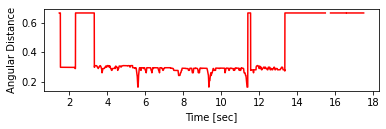

In [24]:
plt.figure(figsize=(6,1.5))
plt.plot(t, osn_axt_dist, c='r')
plt.gca().set(
    ylabel='Angular Distance', 
    xlabel='Time [sec]', 
    # title=r'$d_{\\angle}(\\hat{\\boldsymbol{I}}_o^{OP}(t;\\boldsymbol{\\theta}), \\boldsymbol{I}_o^{OP}(t))$'
)
plt.savefig('angular_distance_current.pdf')

In [25]:
b, a = butter(5, 15, fs=1 / dt)
stim_smooth = lfilter(b, a, np.clip(stim, 0, np.inf))
d_stim = np.diff(stim_smooth, prepend=stim_smooth[0]) / dt
contrast_stim = d_stim / (1. + stim_smooth)

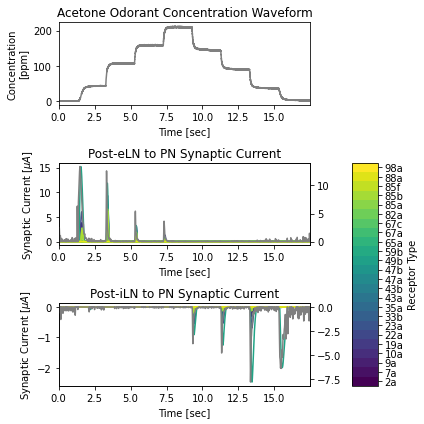

In [26]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
cmap2 = mpl.cm.viridis

fig = plt.figure(figsize=(6,6))
gs = GridSpec(3,2, width_ratios=[10,1])

ax_inp = fig.add_subplot(gs[0,0])
ax0 = fig.add_subplot(gs[1,0], sharex=ax_inp)
ax1 = fig.add_subplot(gs[2,0], sharex=ax0)
ax_cbar = fig.add_subplot(gs[1:,1])

ax_inp.plot(t, stim, c='gray')
ax_inp.set(ylabel='Concentration\n[ppm]', xlabel='Time [sec]', title='Acetone Odorant Concentration Waveform', xlim=[min(t), max(t)])
ax0_2 = ax0.twinx()
ax0_2.plot(t, np.clip(contrast_stim, 0, np.inf), c='gray')
ax1_2 = ax1.twinx()
ax1_2.plot(t, np.clip(contrast_stim, -np.inf, 0), c='gray')

for n, (_eln, _iln) in enumerate(zip(
    posteln_to_pn.recorder.I, postiln_to_pn.recorder.I
)):
    _ = ax0.plot(t, _eln, c=cmap2(n/N_r))
    _ = ax1.plot(t, _iln, c=cmap2(n/N_r))
ax0.set(xlabel='Time [sec]', ylabel='Synaptic Current [$\mu A$]', title='Post-eLN to PN Synaptic Current', xlim=[min(t), max(t)])
ax1.set(xlabel='Time [sec]', ylabel='Synaptic Current [$\mu A$]', title='Post-iLN to PN Synaptic Current', xlim=[min(t), max(t)])


bounds = np.arange(-.5, N_r)
norm = mpl.colors.BoundaryNorm(bounds, cmap2.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap2),
             cax=ax_cbar, orientation='vertical', ticks=bounds+.5,
             label="Receptor Type")
ax_cbar.set_yticklabels(df_aff.columns.astype(str))
fig.tight_layout()
fig.savefig('posteln_postiln_psth.pdf')

[(-2.5, 0.1)]

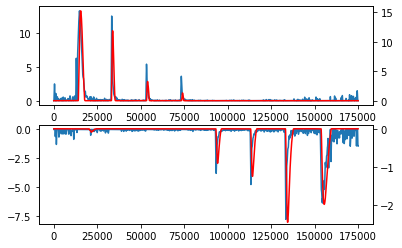

In [50]:
fig,axes = plt.subplots(2,1)
axes[0].plot(np.clip(contrast_stim, 0, np.inf))
ax2 = axes[0].twinx()
ax2.plot(posteln_to_pn.recorder.I.max(0), '-r')

axes[1].plot(np.clip(contrast_stim, -np.inf, 0))
ax2 = axes[1].twinx()
ax2.plot(postiln_to_pn.recorder.I.min(0), '-r')
ax2.set(ylim=[-2.5, 0.1])

In [ ]:
or59b_idx, = np.where(df_aff.columns=='59b')
or59b_idx = or59b_idx.item()

In [ ]:
from antennal_lobe import experiments as exp

In [ ]:
from scipy.optimize import lsq_linear

In [ ]:
pn_I = exp.data.estimate_current(pn, resting=1)
# pn_mask = pn_I >= 7.6

In [ ]:
lsq_linear(
    np.vstack([
        osn_axt_to_pn.recorder.I[or59b_idx],
        posteln_to_pn.recorder.I[or59b_idx],
        postiln_to_pn.recorder.I[or59b_idx],
    ]).T, 
    pn_I,
    bounds=[(0., 0., -np.inf), (np.inf, np.inf, 0.)]
)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,3))
ax.plot(t, pn, c='gray', lw=2)
ax.plot(t, pn_bsg.recorder.x[or59b_idx] / dt, c='r', lw=2)
ax.set(xlabel='Time [sec]', xlim=[min(t), max(t)], title='DM4 PN PSTH', ylabel='PSTH [Hz]')
fig.savefig('dm4_pn_psth.pdf')

In [ ]:
x = np.arange(100)
# Here are many sets of y to plot vs. x
ys = x[:50, np.newaxis] + x[np.newaxis, :]

In [ ]:
segs = np.stack([
    np.repeat(t[None,::1000], 24, axis=0),
    pn_bsg.recorder.x[:,::1000] / dt
], axis=2)

In [ ]:
from matplotlib.collections import LineCollection

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np


fig,ax = plt.subplots(
    1,1,subplot_kw=dict(projection='3d'),
    figsize=(10,12)
)
line_segments = LineCollection(
    segs[::-1],
    colors=[plt.cm.viridis(n/24) for n in range(24)],
    linewidth=2
    # facecolors=[plt.cm.viridis(n/24) for n in range(24)], 
    # edgecolors='white',
    # linestyle='solid',
    # alpha=.5
)
ax.add_collection3d(
    line_segments,  
    zs=np.arange(24)[::-1],
    zdir='y'
)
ax.set(
    xlim=[0, max(t)], ylim=[-1, N_r], zlim=[0,150],
    yticks=np.arange(N_r)[::-1], yticklabels=df_aff.columns[::-1],
    xlabel='Time [sec]', ylabel='Receptor Type', zlabel='PSTH [Hz]',
    aspect='auto'
)
ax.view_init(30, -75)
plt.show()

In [ ]:
??ax.view_init

## 3D View

# Complex Waveforms

## White Noise

In [179]:
import h5py

In [180]:
f = h5py.File('../../al_rfc/data/data.h5')
fig,axes = plt.subplots(2,1, sharex=True)
psth_t = f['white_noise/psth/x'][()]
psth = f['white_noise/psth/y'][()]
stim_t = f['white_noise/stimulus/x'][()]
stim = f['white_noise/stimulus/y'][()]
axes[0].plot(stim_t, stim)
axes[1].plot(psth_t, psth)
f.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [181]:
t = np.arange(min(stim_t), max(stim_t), dt)
wav = np.interp(t, stim_t, stim)

In [182]:
nn_rate = Network(solver="euler")
inp = nn_rate.input(num=1, name='stim')
inp_repeat = nn_rate.add(Repeat, num=1, rep_size=N_r, name='stim-rep')
osn_otp = nn_rate.add(OTP, num=N_r, br=dr*aff, dr=dr, name='OSN-OTP')
osn_bsg = nn_rate.add(PoissonCSN, num=N_r, name='OSN-BSG')

osn_axt = nn_rate.add(dDNP, num=N_r, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn_rate.add(IonSyn, num=N_r, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn_rate.add(PreLN, num=N_r, operation='norm-2', block_size=N_r, name="Pre-LN Input")
preln = nn_rate.add(PoissonCSN0, num=N_r, name="Pre-LN")
osn_axt_to_pn = nn_rate.add(IonSyn, num=N_r, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn_rate.add(PostLNSyn, num=N_r, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn_rate.add(PoissonCSN0, num=N_r, name="Post-eLN")
posteln_to_pn = nn_rate.add(IonSyn, num=N_r, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn_rate.add(PostLNSyn, num=N_r, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn_rate.add(PoissonCSN0, num=N_r, name="Post-iLN")
postiln_to_pn = nn_rate.add(IonSyn, num=N_r, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn_rate.add(Add, num=N_r, name='PN-Dendrite')
pn_bsg = nn_rate.add(PoissonCSN1, num=N_r, name='PN-BSG')

inp_repeat(input=inp)
osn_otp(stimulus=inp_repeat.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.x, l=preln.x)

preln_syn(u=osn_axt.x1)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)
osn_axt_to_pn(u=osn_axt.x1)

posteln_syn(u=osn_bsg.x)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.x)

postiln_syn(u=osn_bsg.x)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.x)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn_rate.compile(dtype=float, backend="cuda")

osn_bsg.record('x')
posteln.record('x')
postiln.record('x')
posteln_syn.record('x1','I')
postiln_syn.record('x1','I')

posteln_to_pn.record('I')
postiln_to_pn.record('I')

osn_axt.record('x1')
osn_axt_to_pn.record('I')
preln.record('x')
pn_bsg.record('x')
pn_inp.record('output')

In [183]:
# wav_filt = lfilter(*butter(5, 5, fs=1/dt), wav)
# wav = (.5 - .5*np.cos(t**2)) * 100
inp_g = garray.to_gpu(np.ascontiguousarray(6*wav))
inp(inp_g)

nn_rate.run(dt, verbose=True)

  0%|          | 0/120000 [00:00<?, ?it/s]

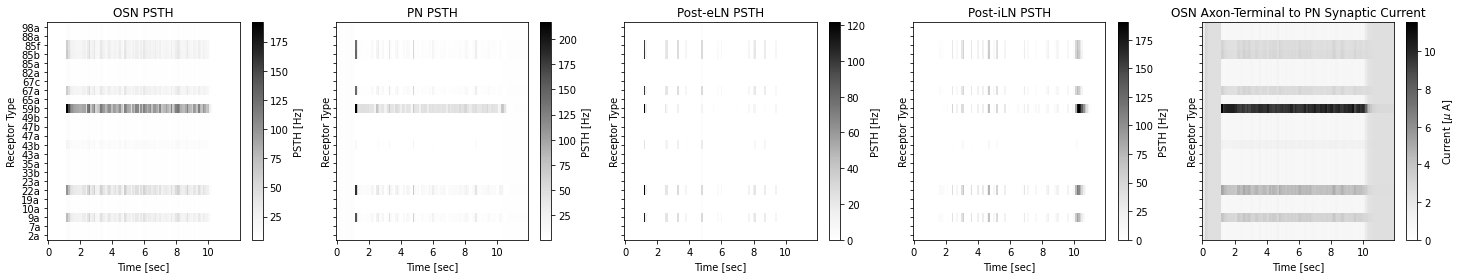

In [60]:
%matplotlib inline
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')

[Text(0.5, 1.0, 'Acetone white noise waveform')]

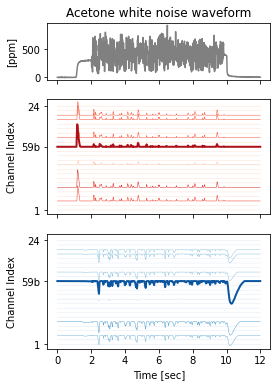

In [63]:
%matplotlib inline
ds = 100

fig, (ax_inp, ax_on, ax_off) = plt.subplots(3,1,sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]), figsize=(4,6))

on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], 6*wav[::ds], c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off) in enumerate(zip(on_all, off_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off])]
ax_off.set(xlabel='Time [sec]')
ax_inp.set(title='Acetone white noise waveform')
# fig.savefig('whitenoise_step_onoff.pdf')

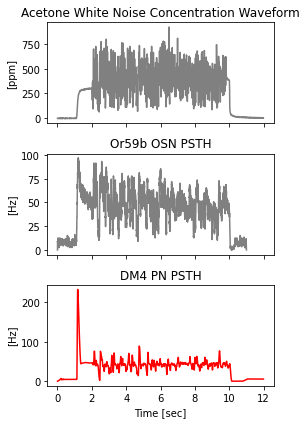

In [64]:
fig,axes = plt.subplots(3,1, figsize=(4, 6), sharex=True)
axes[0].plot(t[::ds], 6*wav[::ds], c='grey')
axes[1].plot(psth_t, psth, c='grey')
axes[2].plot(t[::ds], estimate_spike_rate(pn_inp.recorder.output[14], resting=1)[::ds], c='red')
axes[0].set(ylabel='[ppm]', title='Acetone White Noise Concentration Waveform')
axes[1].set(ylabel='[Hz]', title='Or59b OSN PSTH')
axes[2].set(ylabel='[Hz]', title='DM4 PN PSTH', xlabel='Time [sec]')
fig.tight_layout()
# fig.savefig('white_noise_or59b_dm4.pdf')

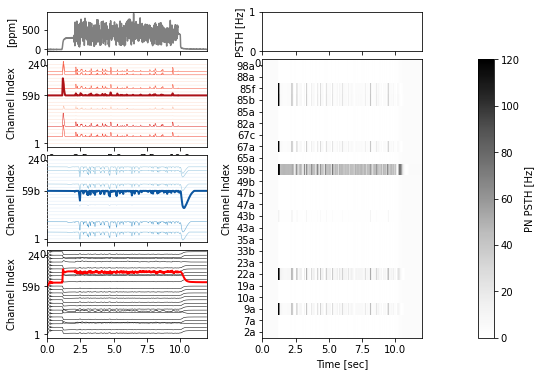

In [365]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = GridSpec(7,3, figure=fig, width_ratios=[10,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt = (    
    fig.add_subplot(gs[1:3,0], sharex=ax_inp),
    fig.add_subplot(gs[3:5,0], sharex=ax_inp),
    fig.add_subplot(gs[5:7,0], sharex=ax_inp),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,2])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], 6*wav[::ds], c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    y_axt = 5*axt / np.abs(axt_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
    _ = ax_axt.plot(t[::ds], np.ones_like(t[::ds])*i + y_axt[::ds], c='k' if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
# ax_dm4.plot(t, pn, c='grey')
# ax_dm4.plot(t, nn_rate.containers['PN-BSG'].recorder.x[14]/dt, c='r')
cax = ax_pn.pcolormesh(t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True, vmin=0, vmax=120)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
fig.savefig('whitenoise_full_io.pdf')

### Phase Space

In [184]:
N_pn = 15

In [185]:
pn_inp_I = pn_inp.recorder.output
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), 1e-5)
pn_inp_I_long = np.vstack([np.interp(t_long, t, _I) for _I in pn_inp_I])
pn_inp_I_long_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I_long.T))

In [186]:
nn_pn = Network()
csn_inp = nn_pn.input(num=N_r)
csn_rep = nn_pn.add(Repeat, num=N_r, rep_size=N_pn)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_long_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1199990 [00:00<?, ?it/s]

In [189]:
n_idx, t_idx = np.where(csn_neuron_1_pn.recorder.spike)

In [188]:
from matplotlib.gridspec import GridSpec

In [108]:
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()

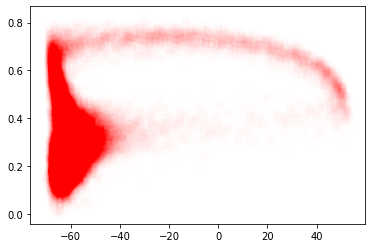

In [195]:
%matplotlib inline
v = csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1))
n = csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1))

plt.scatter(
    v[14,0][t_mask][::ds],
    n[14,0][t_mask][::ds],
    lw=3,
    alpha=.002, c='r', marker='s',
)

In [193]:
%matplotlib widget
v = csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1))
n = csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1))

fig = plt.figure(figsize=(4,7))
gs = GridSpec(3,1,figure=fig, height_ratios=[1,1,4])
ax_inp = fig.add_subplot(gs[0])
ax_out = fig.add_subplot(gs[1])
ax_3d = fig.add_subplot(gs[-1], projection='3d')
# ax_3d = fig.add_subplot(gs[-1])
ds = 10

out = estimate_spike_rate(
    pn_inp.recorder.output[14],
    resting=1
)
ax_inp.plot(t[::int(ds//10)], wav[::int(ds//10)], c='grey')
ax_out.plot(t[::int(ds//10)], out[::int(ds//10)], c='grey')

t_mask = np.logical_and(t_long>=2, t_long <= 9.5)

# ax_3d.plot(
#     v[14,0][t_mask][::ds], 
#     n[14,0][t_mask][::ds], 
#     lw=3,
#     alpha=.5, c='r'
# )

# lc_v,lc_n =lc_clean[I]['v'], lc_clean[I]['n']
# ax_3d.plot(
#     lc_v,
#     lc_n,
#     lw=3,
#     c='k'
# )


ax_3d.scatter(
    v[14,0][t_mask][::ds],
    n[14,0][t_mask][::ds],
    pn_inp_I_long[14][t_mask][::ds],
    lw=3,
    alpha=.002, c='r', marker='s',
    rasterized=True
)


norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 30, 3):
    c = 'grey'
    lw=1
    alpha=.5
    if I in lc_clean:
        v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
        ax_3d.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
        ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)

I = np.round(pn_inp_I_long[14, t_mask].mean())
lc_v,lc_n =lc_clean[I]['v'], lc_clean[I]['n']
ax_3d.plot(
    lc_v,
    lc_n,
    np.ones_like(lc_v)*I,
    lw=3,
    c='k'
)

ax_3d.set(zticks=[0,9,20,30])
ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax_3d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_3d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax_3d.view_init(azim=-31, elev=18)
fig.savefig('white_noisy_3d.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

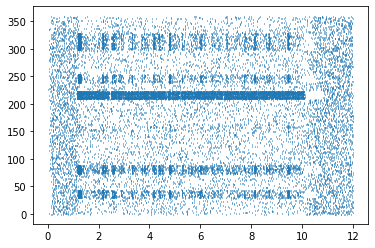

In [73]:
plt.figure()
plt.plot(t_long[t_idx], n_idx, '|', markersize=1)

In [17]:
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()

In [549]:
v.shape

(1085,)

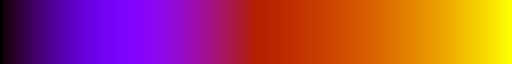

In [586]:
plt.cm.gnuplot

In [589]:
%matplotlib widget
fig = plt.figure(figsize=(4,8))
gs = GridSpec(3, 1, figure=fig, height_ratios=[1,1,3])
ax_inp = fig.add_subplot(gs[0])
ax_rate = fig.add_subplot(gs[1], sharex=ax_inp)
ax_inp.plot(t[::ds], wav[::ds], color='grey')
ax_rate.plot(t[::ds], estimate_spike_rate(pn_inp.recorder.output[14], resting=1)[::ds], color='grey')
# ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[0,2]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)

ax_3d = fig.add_subplot(gs[2], projection='3d')


norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 50, 4):
    c = 'grey'
    lw=1
    alpha=.5
    if I in lc_clean:
        v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
        ax_3d.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
        ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)


ax_3d.set(zticks=[0,9,20,30,40,50])
ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax_3d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_3d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(15) 
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15) 
# for tick in ax.zaxis.get_major_ticks():
#     tick.label.set_fontsize(15) 
ax_3d.view_init(azim=-31, elev=18)

I_on = pn_inp.recorder.output[14].max()
I_ss = pn_inp.recorder.output[14, int(2//dt):int(9//dt)].mean()
v,n =lc_clean[9]['v'][::5], lc_clean[9]['n'][::5]
ax_3d.plot(v, n, np.ones_like(v)*I_ss, c='black', lw=2, alpha=1)

v,n = lc_noisy[8]['v'][::5], lc_noisy[8]['n'][::5]
ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*8, c=plt.cm.gnuplot(.2), lw=2, alpha=1)

v,n =lc_clean[11]['v'][::5], lc_clean[11]['n'][::5]
ax_3d.plot(v, n, np.ones_like(v)*11, c=plt.cm.gnuplot(.2), lw=2, alpha=1)

v,n =lc_clean[int(I_on)]['v'][::5], lc_clean[int(I_on)]['n'][::5]
ax_3d.plot(v, n, np.ones_like(v)*I_on, c='red', lw=2, alpha=1)

v,n = lc_noisy[0]['v'][::5], lc_noisy[0]['n'][::5]
ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*0, c='blue', lw=2, alpha=1)

# for i, (_t, ax) in enumerate(zip(t_plot, ax_3d)):
#     t_idx = int(_t // 1e-4)
#     I1 = np.ceil(pn_inp_I[0, t_idx])
#     I2 = np.ceil(pn_inp_I[2, t_idx])
#     for I, c in zip([I1, I2], ['blue', 'orange']):
#         if I in lc_clean:
#             v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
#             ax.plot(v, n, np.ones_like(v)*I, c=c, lw=2, alpha=1)
#         elif I in lc_noisy:
#             v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
#             ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=2, alpha=1)
fig.savefig('white_noise_dm4_phase_space.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [574]:
np.mean(pn_inp.recorder.output[14, int(2//dt):int(9//dt)]) - np.std(pn_inp.recorder.output[14, int(2//dt):int(9//dt)])

8.022895293056951

In [575]:
np.mean(pn_inp.recorder.output[14, int(2//dt):int(9//dt)]) + np.std(pn_inp.recorder.output[14, int(2//dt):int(9//dt)])

11.153375704255684

In [572]:
np.mean(pn_inp.recorder.output[14, int(2//dt):int(9//dt)])

9.588135498656317

In [567]:
plt.figure()
plt.hist(pn_inp.recorder.output[14, int(2//dt):int(9//dt)], bins=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([  74.,   34.,   27.,   25.,   22.,   22.,   21.,   20.,   20.,
          21.,   21.,   20.,   20.,   20.,   21.,   20.,   21.,   19.,
          20.,   19.,   19.,   18.,   20.,   18.,   96.,   63.,  124.,
          94.,   84.,  188.,  225.,  237.,  198.,  197.,  384.,  396.,
         420.,  634.,  544.,  416.,  609.,  692.,  643.,  830.,  948.,
        1040., 1025., 1110., 1574., 1666., 2225., 2695., 3946., 5298.,
        5283., 6289., 6680., 4985., 3854., 2124., 1148.,  973.,  711.,
         639.,  732.,  835.,  524.,  473.,  504.,  372.,  554.,  405.,
         432.,  477.,  218.,  219.,  291.,  132.,  147.,  172.,  256.,
         213.,  212.,  146.,   88.,  116.,  138.,   19.,   21.,   22.,
          25.,   29.,   33.,   36.,   36.,   39.,   39.,   40.,   48.,
         108.]),
 array([ 1.38704141,  1.53704187,  1.68704234,  1.8370428 ,  1.98704327,
         2.13704373,  2.28704419,  2.43704466,  2.58704512,  2.73704559,
         2.88704605,  3.03704651,  3.18704698,  3.337047

In [542]:
I_ss

9.588135498656317

In [541]:
I_on

49.121762731547264

## Noisy Staircase

In [366]:
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]
pn = data['pn_output'][2]
dt = t[1] - t[0]

### Multiplicative Noise

In [409]:
# wav = np.clip(stim + (stim > 20) * np.random.randn(*t.shape)*100, 0, np.inf)
wav = np.clip(stim * (1+np.random.randn(*t.shape)*.3), 0, np.inf)

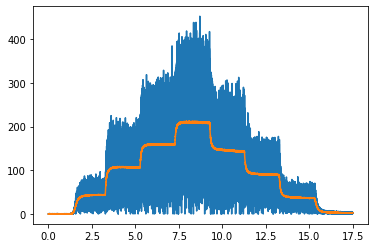

In [410]:
plt.plot(t, wav)
plt.plot(t, stim)

In [411]:
# wav_filt = lfilter(*butter(5, 5, fs=1/dt), wav)
# wav = (.5 - .5*np.cos(t**2)) * 100
inp_g = garray.to_gpu(np.ascontiguousarray(wav))
inp(inp_g)

In [412]:
nn_rate.run(dt, verbose=True)

  0%|          | 0/175000 [00:00<?, ?it/s]

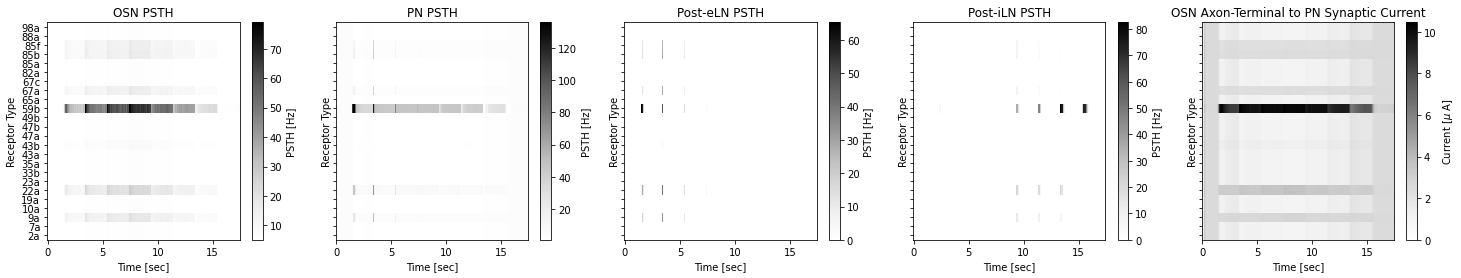

In [414]:
%matplotlib inline
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')

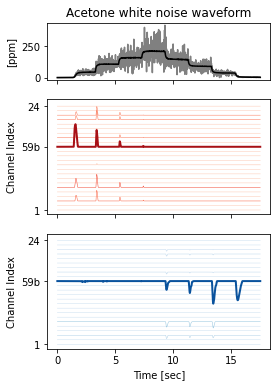

In [423]:
%matplotlib inline
ds = 100

fig, (ax_inp, ax_on, ax_off) = plt.subplots(3,1,sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]), figsize=(4,6))

on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], wav[::ds], c='grey')
ax_inp.plot(t[::ds], stim[::ds], c='k')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_off.set(xlabel='Time [sec]')
ax_inp.set(title='Acetone white noise waveform')
fig.savefig('whitenoise_staircase_onoff.pdf')

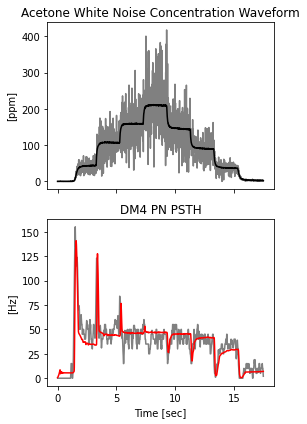

In [424]:
fig,axes = plt.subplots(2,1, figsize=(4, 6), sharex=True)
axes[0].plot(t[::ds], wav[::ds], c='grey')
axes[0].plot(t[::ds], stim[::ds], c='k')

# axes[1].plot(psth_t, psth, c='grey')
axes[1].plot(t[::ds], pn[::ds], c='grey')
axes[1].plot(t[::ds], estimate_spike_rate(pn_inp.recorder.output[14], resting=1)[::ds], c='red')
axes[0].set(ylabel='[ppm]', title='Acetone White Noise Concentration Waveform')
axes[1].set(ylabel='[Hz]', title='DM4 PN PSTH', xlabel='Time [sec]')
fig.tight_layout()
fig.savefig('noisy_staircase_or59b_dm4.pdf')

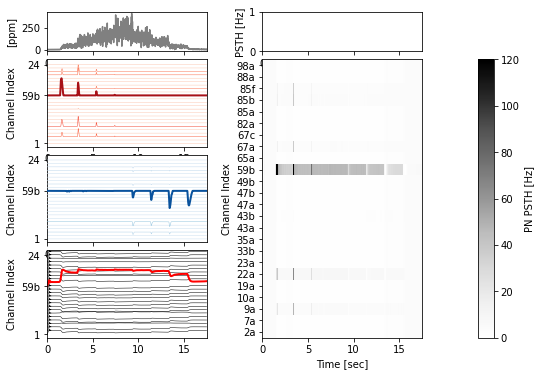

In [426]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = GridSpec(7,3, figure=fig, width_ratios=[10,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt = (    
    fig.add_subplot(gs[1:3,0], sharex=ax_inp),
    fig.add_subplot(gs[3:5,0], sharex=ax_inp),
    fig.add_subplot(gs[5:7,0], sharex=ax_inp),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,2])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], wav[::ds], c='grey')
ax_inp.plot(t[::ds], stim[::ds], c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    y_axt = 5*axt / np.abs(axt_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
    _ = ax_axt.plot(t[::ds], np.ones_like(t[::ds])*i + y_axt[::ds], c='k' if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
# ax_dm4.plot(t, pn, c='grey')
# ax_dm4.plot(t, nn_rate.containers['PN-BSG'].recorder.x[14]/dt, c='r')
cax = ax_pn.pcolormesh(t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True, vmin=0, vmax=120)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
fig.savefig('noisy_staircase_full_io.pdf')

### Additive Noise

In [150]:
wav = np.clip(stim + (stim > 20) * np.random.randn(*t.shape)*100, 0, np.inf)
# wav = np.clip(stim * (1+np.random.randn(*t.shape)*.3), 0, np.inf)

In [151]:
# wav_filt = lfilter(*butter(5, 5, fs=1/dt), wav)
# wav = (.5 - .5*np.cos(t**2)) * 100
inp_g = garray.to_gpu(np.ascontiguousarray(wav))
inp(inp_g)

In [152]:
nn_rate.run(dt, verbose=True)

  0%|          | 0/175000 [00:00<?, ?it/s]

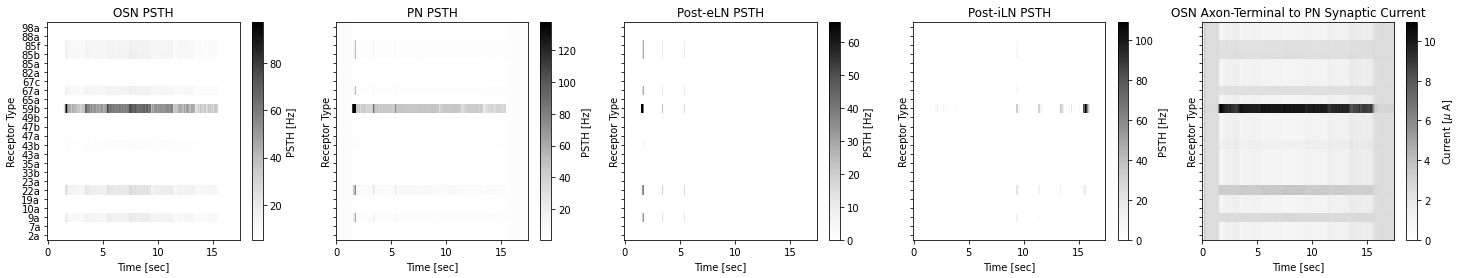

In [153]:
%matplotlib inline
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')

[Text(0.5, 1.0, 'Acetone white noise waveform')]

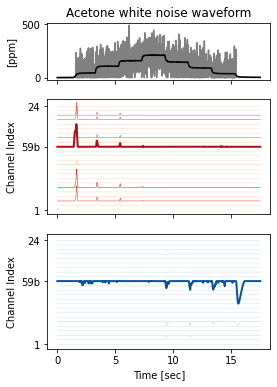

In [156]:
%matplotlib inline
ds = 100

fig, (ax_inp, ax_on, ax_off) = plt.subplots(3,1,sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]), figsize=(4,6))

on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], wav[::ds], c='grey')
ax_inp.plot(t[::ds], stim[::ds], c='k')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off) in enumerate(zip(on_all, off_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off])]
ax_off.set(xlabel='Time [sec]')
ax_inp.set(title='Acetone white noise waveform')
# fig.savefig('whitenoise_staircase_onoff_additive.pdf')

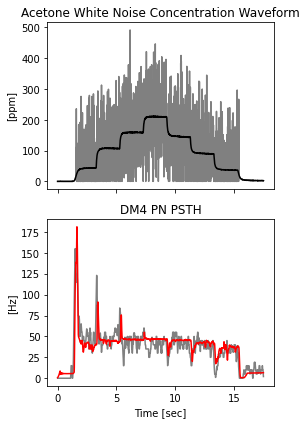

In [157]:
fig,axes = plt.subplots(2,1, figsize=(4, 6), sharex=True)
axes[0].plot(t[::ds], wav[::ds], c='grey')
axes[0].plot(t[::ds], stim[::ds], c='k')

# axes[1].plot(psth_t, psth, c='grey')
axes[1].plot(t[::ds], pn[::ds], c='grey')
axes[1].plot(t[::ds], estimate_spike_rate(pn_inp.recorder.output[14], resting=1)[::ds], c='red')
axes[0].set(ylabel='[ppm]', title='Acetone White Noise Concentration Waveform')
axes[1].set(ylabel='[Hz]', title='DM4 PN PSTH', xlabel='Time [sec]')
fig.tight_layout()
# fig.savefig('noisy_staircase_or59b_dm4_additive.pdf')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = GridSpec(7,3, figure=fig, width_ratios=[10,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt = (    
    fig.add_subplot(gs[1:3,0], sharex=ax_inp),
    fig.add_subplot(gs[3:5,0], sharex=ax_inp),
    fig.add_subplot(gs[5:7,0], sharex=ax_inp),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,2])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = zplt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], wav[::ds], c='grey')
ax_inp.plot(t[::ds], stim[::ds], c='k')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    y_axt = 5*axt / np.abs(axt_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
    _ = ax_axt.plot(t[::ds], np.ones_like(t[::ds])*i + y_axt[::ds], c='k' if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
# ax_dm4.plot(t, pn, c='grey')
# ax_dm4.plot(t, nn_rate.containers['PN-BSG'].recorder.x[14]/dt, c='r')
cax = ax_pn.pcolormesh(t[::100], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::100]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True, vmin=0, vmax=120)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
# fig.savefig('noisy_staircase_full_io_additive.pdf')

#### Phase Space

In [158]:
N_pn = 15

In [159]:
pn_inp_I = pn_inp.recorder.output
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), 1e-5)
pn_inp_I_long = np.vstack([np.interp(t_long, t, _I) for _I in pn_inp_I])
pn_inp_I_long_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I_long.T))

In [160]:
nn_pn = Network()
csn_inp = nn_pn.input(num=N_r)
csn_rep = nn_pn.add(Repeat, num=N_r, rep_size=N_pn)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_long_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

In [161]:
n_idx, t_idx = np.where(csn_neuron_1_pn.recorder.spike)

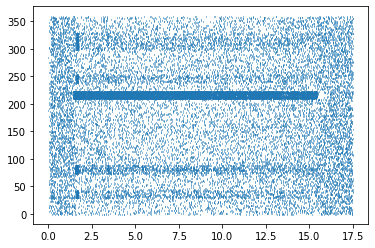

In [162]:
%matplotlib inline
plt.figure()
plt.plot(t_long[t_idx], n_idx, '|', markersize=1)

In [176]:
%matplotlib widget
v = csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1))
n = csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1))

fig = plt.figure(figsize=(4,7))
gs = GridSpec(3,1,figure=fig, height_ratios=[1,1,4])
ax_inp = fig.add_subplot(gs[0])
ax_out = fig.add_subplot(gs[1])
ax_3d = fig.add_subplot(gs[-1], projection='3d')
# ax_3d = fig.add_subplot(gs[-1])
ds = 10

out = estimate_spike_rate(
    pn_inp.recorder.output[14],
    resting=1
)
ax_inp.plot(t[::int(ds//10)], wav[::int(ds//10)], c='grey')
ax_inp.plot(t[::int(ds//10)], stim[::int(ds//10)], c='k')
ax_out.plot(t[::int(ds//10)], out[::int(ds//10)], c='grey')

# t_mask = np.logical_and(t_long>=2.5, t_long <= 15)
t_mask = np.logical_and(t_long>=2.5, t_long <= 15)

# ax_3d.plot(
#     v[14,0][t_mask][::ds], 
#     n[14,0][t_mask][::ds], 
#     lw=3,
#     alpha=.5, c='r'
# )

# lc_v,lc_n =lc_clean[I]['v'], lc_clean[I]['n']
# ax_3d.plot(
#     lc_v,
#     lc_n,
#     lw=3,
#     c='k'
# )


ax_3d.scatter(
    v[14,0][t_mask][::ds],
    n[14,0][t_mask][::ds],
    pn_inp_I_long[14][t_mask][::ds],
    lw=3,
    alpha=.01, 
    c='r', 
    # c=pn_inp_I_long[14][t_mask][::ds],
    cmap=plt.cm.coolwarm,
    norm=mpl.colors.CenteredNorm(vcenter=pn_inp_I_long[14][t_mask][::ds].mean()),
    marker='s',
    rasterized=True
)


norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 30, 3):
    c = 'grey'
    lw=1
    alpha=.5
    if I in lc_clean:
        v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
        ax_3d.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
        ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)

I = np.round(pn_inp_I_long[14, t_mask].mean())
lc_v,lc_n =lc_clean[I]['v'], lc_clean[I]['n']
ax_3d.plot(
    lc_v,
    lc_n,
    np.ones_like(lc_v)*I,
    lw=3,
    c='k'
)

ax_3d.set(zticks=[0,9,20,30])
ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax_3d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_3d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax_3d.view_init(azim=-31, elev=18)
fig.savefig('staircase_noise_3d.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Non-stationary Noise

In [494]:
np.random.seed(0)
t_short = np.arange(0, 5, dt)
wav = 300*np.logical_and(t_short>1, t_short<4.) * np.abs(np.cumsum(100*np.random.randn(*t_short.shape)) * dt)

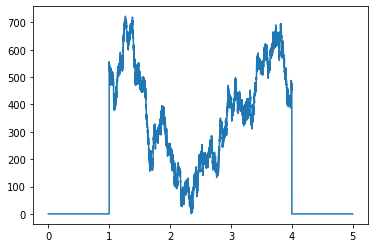

In [495]:
plt.plot(t_short, wav)

In [496]:
# wav_filt = lfilter(*butter(5, 5, fs=1/dt), wav)
# wav = (.5 - .5*np.cos(t**2)) * 100
inp_g = garray.to_gpu(np.ascontiguousarray(wav))
inp(inp_g)

In [497]:
nn_rate.run(dt, verbose=True)

  0%|          | 0/50000 [00:00<?, ?it/s]

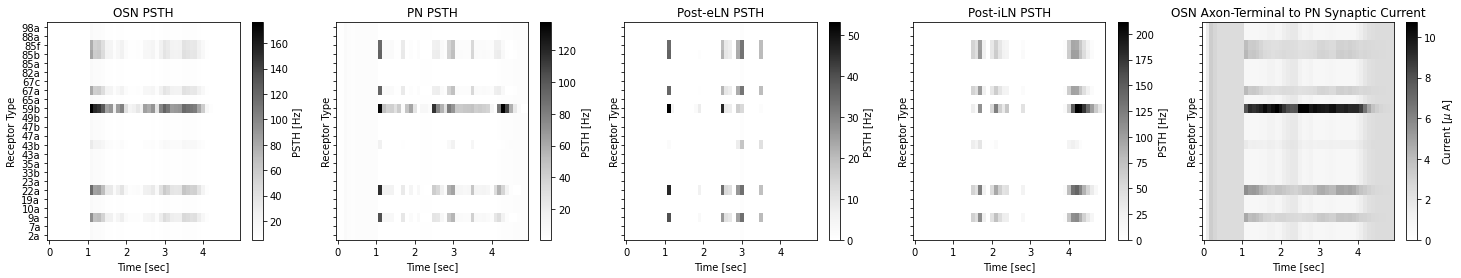

In [498]:
%matplotlib inline
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,5,figsize=(25,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t_short[::ds],
    df_aff.columns,
    osn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='OSN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')

cax = axes[1].pcolormesh(
    t_short[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t_short[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t_short[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[3], label='PSTH [Hz]')
axes[3].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[4].pcolormesh(
    t_short[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap,
    rasterized=True
)
plt.colorbar(cax, ax=axes[4], label='Current [$\mu$ A]')
_ = axes[4].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')

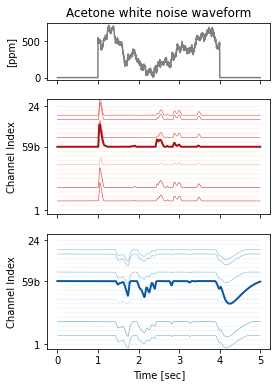

In [510]:
%matplotlib inline
ds = 10

fig, (ax_inp, ax_on, ax_off) = plt.subplots(3,1,sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]), figsize=(4,6))

on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t_short[::ds], wav[::ds], c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t_short[::ds], np.ones_like(t_short[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t_short[::ds], np.ones_like(t_short[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_off.set(xlabel='Time [sec]')
ax_inp.set(title='Acetone white noise waveform')
fig.savefig('brownian_motion_onoff.pdf')

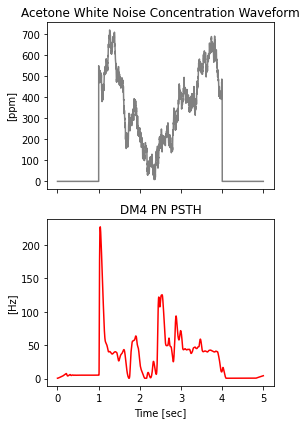

In [503]:

fig,axes = plt.subplots(2,1, figsize=(4, 6), sharex=True)
axes[0].plot(t_short[::ds], wav[::ds], c='grey')
# axes[0].plot(t[::ds], stim[::ds], c='k')

# axes[1].plot(psth_t, psth, c='grey')
# axes[1].plot(t_short[::ds], pn[::ds], c='grey')
axes[1].plot(t_short[::ds], estimate_spike_rate(pn_inp.recorder.output[14], resting=1)[::ds], c='red')
axes[0].set(ylabel='[ppm]', title='Acetone White Noise Concentration Waveform')
axes[1].set(ylabel='[Hz]', title='DM4 PN PSTH', xlabel='Time [sec]')
fig.tight_layout()
# fig.savefig('noisy_staircase_or59b_dm4_additive.pdf')

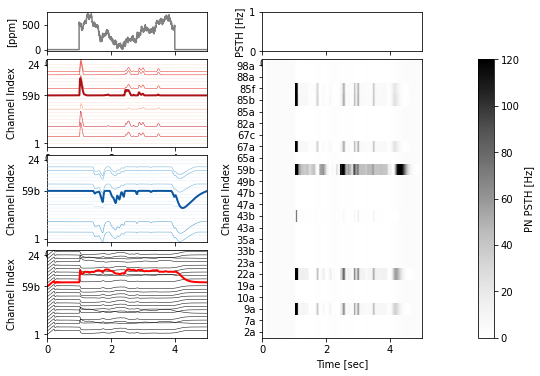

In [509]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = GridSpec(7,3, figure=fig, width_ratios=[10,10,1], wspace=.5)
ax_inp = fig.add_subplot(gs[0,0])
ax_on, ax_off, ax_axt = (    
    fig.add_subplot(gs[1:3,0], sharex=ax_inp),
    fig.add_subplot(gs[3:5,0], sharex=ax_inp),
    fig.add_subplot(gs[5:7,0], sharex=ax_inp),
)
ax_dm4, ax_pn, ax_cbar = (
    fig.add_subplot(gs[0,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,1], sharex=ax_inp),
    fig.add_subplot(gs[1:,2])
)
on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
axt_all = nn_rate.containers['OSN-Axt to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t_short[::ds], wav[::ds], c='grey')
# ax_inp.plot(t[::ds], stim[::ds], c='k')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off,axt) in enumerate(zip(on_all, off_all, axt_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    y_axt = 5*axt / np.abs(axt_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t_short[::ds], np.ones_like(t_short[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t_short[::ds], np.ones_like(t_short[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
    # axes[1].fill_between(t, np.ones_like(y_off)*i, y_off, color=colors(i), zdir='y')
    _ = ax_axt.plot(t_short[::ds], np.ones_like(t_short[::ds])*i + y_axt[::ds], c='k' if i != 14 else 'r', zorder=-i, lw=.5 if i!=14 else 2)
# ax_dm4.plot(t, pn, c='grey')
# ax_dm4.plot(t, nn_rate.containers['PN-BSG'].recorder.x[14]/dt, c='r')
cax = ax_pn.pcolormesh(t_short[::ds], np.arange(N_r), nn_rate.containers['PN-BSG'].recorder.x[:,::ds]/dt, cmap=plt.cm.Greys, shading='nearest', rasterized=True, vmin=0, vmax=120)
plt.colorbar(cax, cax=ax_cbar, label='PN PSTH [Hz]')
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off, ax_axt])]
ax_dm4.set(ylabel='PSTH [Hz]')
_ = ax_pn.set(ylabel='Channel Index', yticks=np.arange(N_r), yticklabels=df_aff.columns, xlabel='Time [sec]')
# fig.savefig('noisy_staircase_full_io_additive.pdf')

## Step-Ramp-Parabola

In [196]:
f = h5py.File('../../al_rfc/data/data.h5')
# fig,axes = plt.subplots(2,1, sharex=True)
stim = np.concatenate([
    f['elife15/step/stimulus/y'][()][0],
    f['elife15/ramp/stimulus/y'][()][0],
    f['elife15/parabola/stimulus/y'][()][0],
])
stim = np.concatenate([stim[:3000], stim])
stim_dt = np.diff(f['elife15/step/stimulus/x'][()])[0]
f.close()

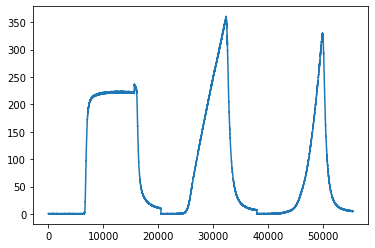

In [197]:
%matplotlib inline
plt.figure()
plt.plot(stim)

In [198]:
t_stim = np.arange(len(stim))*stim_dt
dt = 1e-4
t = np.arange(min(t_stim), max(t_stim), dt)
wav = np.interp(t, t_stim, stim)

In [199]:
# wav_filt = lfilter(*butter(5, 5, fs=1/dt), wav)
# wav = (.5 - .5*np.cos(t**2)) * 100
inp_g = garray.to_gpu(np.ascontiguousarray(wav))
inp(inp_g)

In [200]:
nn_rate.run(dt, verbose=True)

  0%|          | 0/110993 [00:00<?, ?it/s]

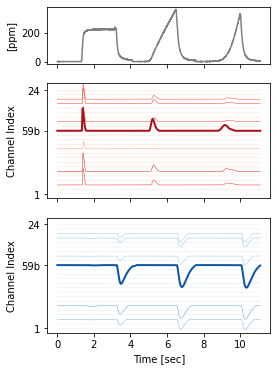

In [201]:
%matplotlib inline
ds = 10

fig, (ax_inp, ax_on, ax_off) = plt.subplots(3,1,sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]), figsize=(4,6))

on_all = nn_rate.containers['Post-eLN to PN'].recorder.I
off_all = nn_rate.containers['Post-iLN to PN'].recorder.I
colors = plt.cm.get_cmap('viridis', N_r)
ax_inp.plot(t[::ds], wav[::ds], c='grey')
ax_inp.set(ylabel='[ppm]')

on_norm = mpl.colors.Normalize(vmin=-5, vmax=np.abs(on_all).max()*1.2)
off_norm = mpl.colors.Normalize(vmin=-2, vmax=np.abs(off_all).max()*1.2)

for i, (on,off) in enumerate(zip(on_all, off_all)):
    y_on = 5*on / np.abs(on_all).max()
    y_off = 5*off / np.abs(off_all).max()
    # c = plt.cm.coolwarm()
    _ = ax_on.plot(t[::ds], np.ones_like(t[::ds])*i + y_on[::ds], c=plt.cm.Reds(on_norm(np.abs(on).max())) , zorder=-i, lw=.5 if i!=14 else 2)
    # axes[0].fill_between(t, np.ones_like(y_on)*i, y_on, color=colors(i), zdir='y')
    _ = ax_off.plot(t[::ds], np.ones_like(t[::ds])*i + y_off[::ds], c=plt.cm.Blues(off_norm(np.abs(off).max())) , zorder=i, lw=.5 if i!=14 else 2)
_ = [ax.set(
    yticks=[0, 14, N_r-1], 
    ylim=[-1, N_r+.5], 
    yticklabels=[1, '59b', N_r], 
    ylabel='Channel Index'
) for i, ax in enumerate([ax_on, ax_off])]
ax_off.set(xlabel='Time [sec]')
fig.savefig('step_Ramp_para_on_off.pdf')

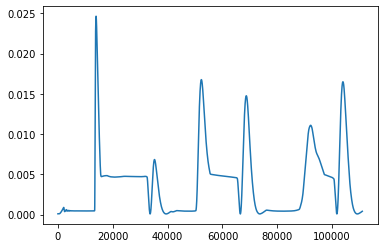

In [202]:
%matplotlib inline
plt.figure()
plt.plot(pn_bsg.recorder.x[14])

# Noise Free Model

In [225]:
I1 = nn_rate.containers['OSN-Axt to PN'].recorder.I
I2 = nn_rate.containers['Post-eLN to PN'].recorder.I
I3 = nn_rate.containers['Post-iLN to PN'].recorder.I

In [261]:
def cost(x):
    x1, x2, x3 = x
    est = estimate_spike_rate((x1*I1 + x2*I2 + x3*I3)[14], resting=1)
    cost= - snr(
        pn,
        pn-est,
        dt
    )
    print(x1,x2,x3,-cost)
    return cost

In [262]:
from scipy.optimize import minimize

In [251]:
pn_x_0 = estimate_spike_rate(1.12323053*I1+0.83239236*I2+0.62120709*I3, resting=0)
pn_x_1 = estimate_spike_rate(I1+I2+I3, resting=1)

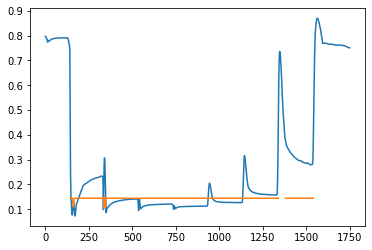

In [259]:
plt.plot(ang_dist(pn_x_1[:,::100].T, aff[None,:]))
plt.plot(ang_dist(pn_x_0[:,::100].T, aff[None,:]))

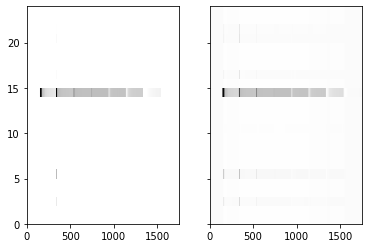

In [252]:
fig,axes = plt.subplots(1,2,sharex=True, sharey=True)
axes[0].pcolormesh(pn_x_0[:,::100], cmap=plt.cm.Greys)
axes[1].pcolormesh(pn_x_1[:,::100], cmap=plt.cm.Greys)

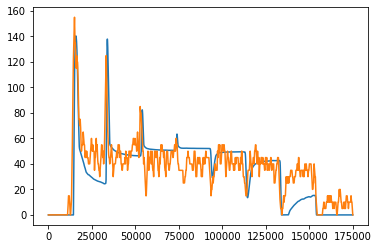

In [247]:
plt.plot(pn_x_0[14])
plt.plot(pn)

# Odorant Affinity Values

In [205]:
concs = (10**np.linspace(1,4,100))
mixture_ratios = (
    np.eye(df_aff.shape[0])[None,...] * concs[:,None,None]
).reshape((-1, df_aff.shape[0]))
affs = df_aff.values.tolist()

In [206]:
mixture_ratios.shape
N_w, N_odorants = mixture_ratios.shape
assert len(affs) == N_odorants
N_r = len(affs[0])
num = N_w * N_r

In [208]:

class MixtureN(Operator):
    def __init__(self, size, aff, dtype=np.float64, **kwargs):
        backend = kwargs.pop('backend', 'cuda')
        super().__init__(size=size, dtype=dtype, backend=backend)
        self.aff_g = []
        for _aff in aff:
            self.aff_g.append(garray.to_gpu(_aff.astype(dtype)))

    def update(self, **inputs_dict):
        inputs = [None]*len(inputs_dict)
        for n, inp in inputs_dict.items():
            inputs[int(n)] = inp
        self._update(*inputs, self.output, *self.aff_g)
        if self._backend != 'cuda':
            if isinstance(self.output, garray.GPUArray):
                self.output = self.output.get()

    def compile(self, **kwargs):
        N_pure = len(self.aff_g)
        if self._backend != 'cuda':
            warn('MixtureN requested compilation of CPU-mode, output post-processed to be CPU compatible')
        inputs = ", ".join(["{} in{}".format(self.dtype, n) for n in range(N_pure)])
        affs = ", ".join(["{} *aff{}".format(self.dtype, n) for n in range(N_pure)])
        self._update = ElementwiseKernel(
            inputs + ", {0} *out, ".format(self.dtype) +  affs,
            "out[i] = " + " + ".join(["in{0}*aff{0}[i]".format(n) for n in range(N_pure)]) + ";",
            "MixtureN")
        


In [226]:
N_w, N_odorants = mixture_ratios.shape
assert len(affs) == N_odorants
N_r = len(affs[0])
num = N_w * N_r

nn = Network()
aff_rep = []
sti_N = {}
for n in range(N_odorants):
    sti_N[str(n)] = (nn.input(name='waveform{}'.format(n),))
    aff_rep.append(np.ravel(mixture_ratios[:, n][:, np.newaxis]*np.tile(affs[n], (N_w,1))))

sti_mix = nn.add(MixtureN, num, name='Mixer', aff=aff_rep)
osn_otp = nn.add(OTP, num=num, name='OTP', br=10., dr=10., Imax=85.)
osn_bsg = nn.add(PoissonCSN, num=num, name='BSG')


osn_axt = nn.add(dDNP, num=num, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn.add(IonSyn, num=num, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn.add(PreLN, num=num, operation='norm-2', block_size=N_r, name="Pre-LN Input")
preln = nn.add(PoissonCSN0, num=num, name="Pre-LN")
osn_axt_to_pn = nn.add(IonSyn, num=num, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn.add(PostLNSyn, num=num, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn.add(PoissonCSN0, num=num, name="Post-eLN")
posteln_to_pn = nn.add(IonSyn, num=num, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn.add(PostLNSyn, num=num, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn.add(PoissonCSN0, num=num, name="Post-iLN")
postiln_to_pn = nn.add(IonSyn, num=num, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn.add(Add, num=num, name='PN-Dendrite')
pn_bsg = nn.add(PoissonCSN1, num=num, name='PN-BSG')


sti_mix(**sti_N)
osn_otp(stimulus=sti_mix.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.x, l=preln.x)

preln_syn(u=osn_axt.x1)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)
osn_axt_to_pn(u=osn_axt.x1)

posteln_syn(u=osn_bsg.x)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.x)

postiln_syn(u=osn_bsg.x)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.x)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn.compile(dtype=float, backend="cuda")

# osn_bsg.record('x')
# posteln.record('x')
# postiln.record('x')
# posteln_syn.record('x1','I')
# postiln_syn.record('x1','I')

# posteln_to_pn.record('I')
# postiln_to_pn.record('I')

# osn_axt.record('x1')
# osn_axt_to_pn.record('I')

        
# preln.record('x')
# pn_bsg.record('x')
# pn_inp.record('output')

In [228]:
dt = 1e-4

In [229]:
from neural.utils import generate_stimulus

In [230]:
for w in nn.inputs:
    u = generate_stimulus('step', dt, 3., (.1, 3.+dt), 1.)
    nn.inputs[w](u)
t = np.arange(len(u))*dt

In [231]:
nn.compile(backend='cuda')
nn.run(dt, verbose=True)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [272]:
osn_spk_ss = nn.containers['BSG'].obj.x.get().reshape((-1, 110, N_r)) / dt
pn_spk_ss = nn.containers['PN-BSG'].obj.x.get().reshape((-1, 110, N_r)) / dt
pn_inp_ss = nn.containers['PN-Dendrite'].obj.output.get().reshape((-1, 110, N_r))

In [241]:
def ang_dist(X, Y=None, paired=False):
    if Y is None:
        Y = X
    if paired is True:
        from sklearn.metrics.pairwise import paired_distances as metric_func
        positive_mask = np.logical_and(np.all(X >= 0, axis=1), np.all(Y >= 0, axis=1))
        zero_mask = np.logical_or(np.all(X == 0, axis=1), np.all(Y == 0, axis=1))
    else:
        from sklearn.metrics import pairwise_distances as metric_func
        positive_mask = np.logical_and(np.all(X >= 0, axis=1), np.all(Y >= 0, axis=1))
        zero_mask = np.logical_or(np.all(X == 0, axis=1), np.all(Y == 0, axis=1))
    cos_sim = np.atleast_1d(np.squeeze(1.0 - metric_func(X=X, Y=Y, metric="cosine")))
    dists = np.arccos(cos_sim) / np.pi
    dists[positive_mask] *= 2
    dists[zero_mask] = np.inf
    return dists

In [245]:
osn_ang_dist = np.zeros((len(concs), N_odorants))
pn_ang_dist = np.zeros((len(concs), N_odorants))
for i in range(len(concs)):
    osn_ang_dist[i] = ang_dist(osn_spk_ss[i], df_aff.values, paired=True)
    pn_ang_dist[i] = ang_dist(pn_spk_ss[i], df_aff.values, paired=True)

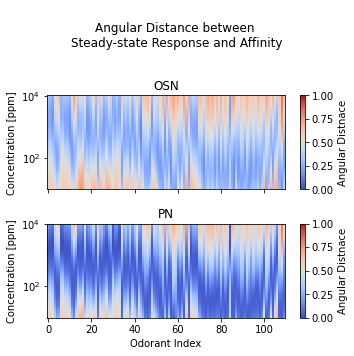

In [269]:
fig,axes = plt.subplots(2,1,sharex=True, sharey=True,figsize=(5,5))
cax = axes[0].pcolormesh(np.arange(N_odorants), concs, osn_ang_dist, cmap=plt.cm.coolwarm, vmin=0,vmax=1, shading='nearest', rasterized=True)
plt.colorbar(cax, ax=axes[0], label='Angular Distnace')
cax = axes[1].pcolormesh(np.arange(N_odorants), concs, pn_ang_dist, cmap=plt.cm.coolwarm, vmin=0,vmax=1, shading='nearest', rasterized=True)
plt.colorbar(cax, ax=axes[1], label='Angular Distnace')
axes[1].set(xlabel='Odorant Index', ylabel='Concentration [ppm]', yscale='log',title='PN')
axes[0].set(ylabel='Concentration [ppm]', title='OSN')
fig.suptitle('''
Angular Distance between 
Steady-state Response and Affinity
''')
fig.tight_layout()
fig.savefig('affinity_comparison.pdf')

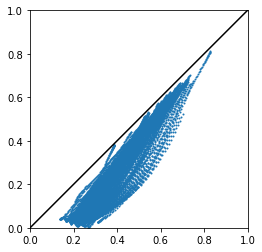

In [289]:
plt.scatter(osn_ang_dist.ravel(), pn_ang_dist.ravel(), s=1)
plt.plot([0,1], [0,1], c='k')
plt.xlim([0,1])
plt.ylim([0,1])

plt.gca().set_aspect(1)

In [316]:
set(np.round(pn_inp_ss[[33,40,66],49]).ravel().tolist())

{1.0, 2.0, 3.0, 4.0, 5.0, 9.0, 10.0}

In [368]:
np.argsort(np.std(pn_inp_ss[[33,56,66]], axis=0).mean(-1))

array([ 84,  34,  54,  11,  40,  51, 104,  38,  30,  57,  59, 109,  28,
        43,   6,  56,  50,   4,  88,  79,  13, 103, 102,   3,  87,  41,
        60,   7,  62,  97,  17,  95,  45, 100,   5,  49,  44,  90,  81,
        96,  85,  94,  72,  33, 107,  58,  91,  19,  70,  68,  65,  47,
        61,  21,  92,  35,  69,  32,  83,  29,  86,  12,  99,  52,  73,
        26,  25, 101,  55, 105,  36,  20,  74,   0,  78,  42,   1,  63,
        10,  23,  16,  75,  76,  89,  48,  37,  18,  22,  77,  71,   2,
         9,  67,  82,  93,  14,  15,   8,  24,  98,  46,  39,  64,  31,
        27,  53,  80, 106,  66, 108])

In [350]:
np.argsort(np.abs(np.diff(pn_inp_ss[[33,56,66]], axis=0)).sum(0).sum(-1))

array([ 84,  34,  54,  11,  51,  28,  40,  38,  30,  43,  59,  57,  56,
        50, 104,   6, 103,   4, 109,   3,  13,  79,  88, 102,  87,  41,
        60,  17,  62,   7,   5,  49,  97,  44,  95,  81, 100,  96,  45,
        90,  19,  33, 107,  85,  68,  72,  94,  69,  35,  21,  70,  61,
        58,  91,  32,  47,  65,  26,  83, 105,  29,  99,  25,  12,  92,
        52,  20,  86,  73,  55,  36,  74,  10,   0,  42, 101,   1,  16,
        37,  18,  48,  23,  78,  22,  76,  67,  63,   9,  75,   2,  89,
        15,  71,  77,  14,  93,   8,  24,  64,  82,  39,  98,  46,  27,
        31, 106,  66,  53,  80, 108])

In [376]:
np.argsort(np.std(pn_ang_dist[30:60] - pn_ang_dist[30:60].mean(0)[None,:], axis=0))

array([ 11,  54,  56,  13,  49,  40, 103,  28,   3,  17,  43,  38, 100,
        21,  29, 105,  60,  36,  35,  51,  50,  57, 109,  25,  94,  12,
         4,  47,  62,  91,  86,  53,  59,  69,  19,  58,  68,  10,   5,
        72,  37,  67,  64,  79,  26,  23,  87,  77, 104, 101,  41,  20,
        44,  24,  84,  88,  45,  70,  34,  52,  39,  18,  90,  48,  99,
        89,  15,  61,  42,  92,  93,  81,  98,  65,  96,  71, 107,  83,
        97,  80,  74,  82,  22,   9,  46,  31,   2,  85,   0,   8,  63,
        95,  66,  55, 102,  30,  73,  75,  78,  33,   6,  27,  76, 106,
         1,  14,  32,   7,  16, 108])

In [357]:
plt.figure()
plt.semilogx(concs, pn_ang_dist[:,108], '-o')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [338]:
np.where(df_aff.index == 'ethyl acetate')

(array([87]),)

In [336]:
plt.pcolormesh(pn_inp_ss[:,50])

In [ ]:
pn_inp_ss[:,49]

In [324]:
pn_spk_ss.shape

(100, 110, 24)

In [ ]:
df_aff.iloc[o_idx, channel_idx] == 1e-5

True

In [408]:
df_aff.index[[49, 11, 56]]

Index(['acetone', 'butyric acid', 'benzyl alcohol'], dtype='object')

In [404]:
%matplotlib widget
fig,axes = plt.subplots(3,3,figsize=(10,9), subplot_kw=dict(projection='3d'))

cs = plt.cm.get_cmap('viridis', N_r)
for row, o_idx in enumerate([49, 11, 56]):
    for ctr, idx in enumerate([33,56,66]):
        ax_3d = axes[row, ctr]
        I_all = np.round(pn_spk_ss[idx, o_idx, :])
        for channel_idx, I in enumerate(I_all):
            if df_aff.iloc[o_idx, channel_idx] == 1e-5:
                c = 'grey'
            else:
                cs(channel_idx)
            if I in lc_clean:
                v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
                ax_3d.plot(v, n, np.ones_like(v)*I, c=cs(channel_idx), lw=2, alpha=1, zorder=I-.1*channel_idx, rasterized=True)
            elif I in lc_noisy:
                v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
                ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=cs(channel_idx), lw=2, alpha=1, zorder=I-.1*channel_idx, rasterized=True)

        ax_3d.set(zticks=[0,9,20,30,40], title=f"Concentration {concs[idx]:.0f} ppm", xlim=[-60,60], ylim=[0,1], zlim=[0,40])
        ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        ax_3d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax_3d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

        ax_3d.view_init(azim=-31, elev=18)
fig.savefig('concentration_lc_manifolds.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [410]:
%matplotlib widget
fig,axes = plt.subplots(3,3,figsize=(10,9), subplot_kw=dict(projection='3d'))

cs = plt.cm.get_cmap('Spectral', N_r)
for row, o_idx in enumerate([49, 11, 56]):
    for ctr, idx in enumerate([33,56,66]):
        ax_3d = axes[row, ctr]
        I_all = np.round(pn_spk_ss[idx, o_idx, :])
        for channel_idx, I in enumerate(I_all):
            if df_aff.iloc[o_idx, channel_idx] == 1e-5:
                c = 'grey'
            else:
                cs(channel_idx)
            if I in lc_clean:
                v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
                ax_3d.plot(v, n, np.ones_like(v)*I, c=cs(channel_idx), lw=2, alpha=1, zorder=I-.1*channel_idx, rasterized=True)
            elif I in lc_noisy:
                v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
                ax_3d.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=cs(channel_idx), lw=2, alpha=1, zorder=I-.1*channel_idx, rasterized=True)

        ax_3d.set(zticks=[0,9,20,30,40], title=f"Concentration {concs[idx]:.0f} ppm", xlim=[-60,60], ylim=[0,1], zlim=[0,40])
        ax_3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax_3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        ax_3d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax_3d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

        ax_3d.view_init(azim=-31, elev=18)
fig.savefig('concentration_lc_manifolds.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

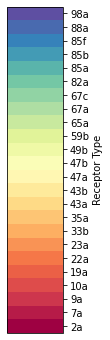

In [411]:
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(1,6))
bounds = np.arange(-.5, N_r)
norm = mpl.colors.BoundaryNorm(bounds, plt.cm.Spectral.N)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.Spectral),
             cax=ax,orientation='vertical', ticks=bounds+.5,
             label="Receptor Type")
ax.set_yticklabels(df_aff.columns.astype(str))
fig.savefig('receptor_types_colorbar.pdf')